# Create Embeddings and Compare Models

## Step 1: Load Libraries

In [55]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34,resnet50,ResNet18_Weights,ResNet34_Weights,ResNet50_Weights
from torchvision.models import resnext50_32x4d, densenet121, alexnet, vgg16, mobilenet_v2,ResNeXt50_32X4D_Weights, DenseNet121_Weights, AlexNet_Weights, VGG16_Weights, MobileNet_V2_Weights
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

For vision transformer

In [56]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from transformers import ViTModel, ViTImageProcessor

For computer vision transformer

In [57]:
# ViTFeatureExtractor by AutoImageProcessor and ViTForImageClassification by CvtForImageClassification).
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from transformers import AutoFeatureExtractor, AutoModel

In [58]:
root_dir = '/home/jupyter/data/train_data'
test_directory = '/home/jupyter/data/test_data'

In [59]:
root_birdnet_dir_test = '/home/jupyter/data/test_data'
root_birdnet_dir_train = '/home/jupyter/data/train_data'

In [60]:
# Load audio files
root_birdnet_analyzer_dir_test = '/home/jupyter/BirdNET-Analyzer/test_data'
root_birdnet_analyzer_dir_train = '/home/jupyter/BirdNET-Analyzer/train_data'

In [61]:
birdnet_model_path = '/home/jupyter/BirdNET-Analyzer/checkpoints/V2.4/BirdNET_GLOBAL_6K_V2.4_Model_FP32.tflite'

## Step 2: Custom Dataset Class

Create a custom dataset class to load the spectrogram images for resnet, efficientnet, alexnet ...

In [62]:
class BirdDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = []
        self.labels = []
        self.label_to_id = {}
        self.id_to_label = {}
        label_id = 0

        for bird_folder in os.listdir(root_dir):
            bird_path = os.path.join(root_dir, bird_folder, 'melspectrogram', 'denoised')
            if os.path.isdir(bird_path):
                if bird_folder not in self.label_to_id:
                    self.label_to_id[bird_folder] = label_id
                    self.id_to_label[label_id] = bird_folder
                    label_id += 1
                for file_name in os.listdir(bird_path):
                    file_path = os.path.join(bird_path, file_name)
                    if os.path.isfile(file_path):  # Only add files, not directories
                        self.files.append(os.path.join(bird_path, file_name))
                        self.labels.append(self.label_to_id[bird_folder])
                    # self.files.append(os.path.join(bird_path, file_name))
                    # self.labels.append(self.label_to_id[bird_folder])
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

Data loader for Bird voice classifier

In [63]:
def load_audio_files(root_dir):
    files = []
    labels = []

    for bird_folder in os.listdir(root_dir):
        bird_path = os.path.join(root_dir, bird_folder, 'segmented_audio', 'denoised')
        if os.path.isdir(bird_path):
            for file_name in os.listdir(bird_path):
                if file_name.endswith('.wav'):
                    files.append(os.path.join(bird_path, file_name))
                    labels.append(bird_folder)
    
    return files, labels

def preprocess_bvc_audio(file_path, duration=2.0, sr=32000, target_duration=5.0):
    # Load the audio file
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    target_length = int(sr * target_duration)
    current_samples = len(y)
    # If the audio is shorter than the target duration, pad with zeros
    if current_samples < target_length:
        pad_length = target_length - current_samples
        pad_left = pad_length // 2
        pad_right = pad_length - pad_left  # This accounts for odd pad_length
        padded_audio = np.pad(y, (pad_left, pad_right), 'constant')
        # print(f"Padding audio from {current_samples} to {target_length} samples")
        return padded_audio
    else:
        return audio[:target_length]  # Truncate if longer than target duration
    # if len(y) < target_length:
    #     y = np.pad(y, (0, target_length - len(y)), 'constant')
    # return y

def pad_audio(file_path, target_duration = 3, sample_rate = 48000):
    """
    Pad the audio with silence evenly on both sides to reach the target duration.
    
    Args:
    audio (np.array): The audio data to pad.
    target_duration (float): The desired duration in seconds.
    sample_rate (int): The sample rate of the audio.

    Returns:
    np.array: The padded audio data.
    """
    y, _ = librosa.load(file_path)
    current_samples = len(y)
    target_samples = int(target_duration * sample_rate)
    
    if current_samples < target_samples:
        pad_length = target_samples - current_samples
        pad_left = pad_length // 2
        pad_right = pad_length - pad_left  # This accounts for odd pad_length
        padded_audio = np.pad(y, (pad_left, pad_right), 'constant')
        # print(f"Padding audio from {current_samples} to {target_samples} samples")
        return padded_audio
    else:
        return audio[:target_samples]  # Truncate if longer than target duration

def preprocess_birdnet_audio(file_path, target_duration=3,sr = 48000):
    """Loads and preprocesses audio file."""
    audio = pad_audio(file_path, target_duration, sr)
    return audio
    
    
# birdnet embedding files

def load_birdnet_embedding_files(root_dir):
    files = []
    labels = []

    for bird_folder in os.listdir(root_dir):
        bird_path = os.path.join(root_dir, bird_folder, 'segmented_audio', 'denoised')
        if os.path.isdir(bird_path):
            for file_name in os.listdir(bird_path):
                if file_name.endswith('.txt'):
                    files.append(os.path.join(bird_path, file_name))
                    labels.append(bird_folder)
    
    return files, labels

def load_birdnet_embedding(embeddings_file):
    embeddings_list = []

    with open(embeddings_file, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                embedding_str = parts[2]
                embedding = np.array([float(value) for value in embedding_str.split(',') if value])
                embeddings_list.append(embedding)

    if not embeddings_list:
        print(f"Warning: No embeddings found in file {embeddings_file}")
        
    embeddings = np.array(embeddings_list)
    return embeddings

def load_birdnet_embeddings_and_labels(file_paths, labels):
    all_embeddings = []
    all_labels = []

    for file_path, label in zip(file_paths, labels):
        embeddings = load_birdnet_embedding(file_path)
        if embeddings.size == 0:
            print(f"Warning: File {file_path} resulted in empty embeddings")
            continue
        all_embeddings.append(embeddings)
        all_labels.append([label] * len(embeddings))

    if not all_embeddings:
        raise ValueError("No valid embeddings found. Please check your input files.")

    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.array([item for sublist in all_labels for item in sublist])

    return all_embeddings, all_labels

In [64]:
  
def save_embeddings_and_labels(model_name, embeddings, labels, output_dir):
    """
    Save embeddings and labels to numpy files.
    
    Args:
    model_name (str): Name of the model used to generate embeddings.
    embeddings (torch.Tensor or np.ndarray): The generated embeddings.
    labels (torch.Tensor or np.ndarray): The corresponding labels.
    output_dir (str): Directory where the files will be saved.
    """
    # Create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert tensors to numpy arrays if necessary
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    # Define file paths
    embeddings_path = os.path.join(output_dir, f"{model_name}_embeddings.npy")
    labels_path = os.path.join(output_dir, f"{model_name}_labels.npy")
    
    # Save embeddings and labels as numpy files
    np.save(embeddings_path, embeddings)
    np.save(labels_path, labels)
    
    print(f"Saved embeddings to {embeddings_path}")
    print(f"Saved labels to {labels_path}")

## Step 3: Data Transformations and Data Loader

In [65]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = BirdDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [66]:
test_dataset = BirdDataset(test_directory, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Step 4: Load models

Load all possible resnet, efficientnet, alexnet, densenet, vgg, alexnet, and mobilenet models:

In [67]:
# Load ResNet models
resnet_models = {
    'resnet18': resnet18(weights=ResNet18_Weights.DEFAULT),
    'resnet34': resnet34(weights=ResNet34_Weights.DEFAULT),
    'resnet50': resnet50(weights=ResNet50_Weights.DEFAULT)
}

for model_name, res_model in resnet_models.items():
    res_model.fc = torch.nn.Identity()  # Modify the last layer to output features directly
    resnet_models[model_name] = res_model.to(device)
    resnet_models[model_name].eval()

# Load EfficientNet models
efficientnet_models = {
    'efficientnet-b0': EfficientNet.from_pretrained('efficientnet-b0'),
    'efficientnet-b1': EfficientNet.from_pretrained('efficientnet-b1'),
    'efficientnet-b2': EfficientNet.from_pretrained('efficientnet-b2'),
    'efficientnet-b3': EfficientNet.from_pretrained('efficientnet-b3'),

}

for model_name, res_model in resnet_models.items():
    res_model._fc = torch.nn.Identity()  # Remove the classification layer
    resnet_models[model_name] = res_model.to(device)
    resnet_models[model_name].eval()

for model_name, eff_model in efficientnet_models.items():
    eff_model._fc = torch.nn.Identity()  # Remove the classification layer
    efficientnet_models[model_name] = eff_model.to(device)
    efficientnet_models[model_name].eval()

# Load ResNeXt50_32x4d
resnext_model = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
resnext_model.fc = torch.nn.Identity()
resnext_model = resnext_model.to(device)
resnext_model.eval()

# Load DenseNet121
densenet_model = densenet121(weights=DenseNet121_Weights.DEFAULT)
densenet_model.classifier = torch.nn.Identity()
densenet_model = densenet_model.to(device)
densenet_model.eval()

# Load AlexNet
alexnet_model = alexnet(weights=AlexNet_Weights.DEFAULT)
alexnet_model.classifier[6] = torch.nn.Identity()
alexnet_model = alexnet_model.to(device)
alexnet_model.eval()

# Load VGG16
vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
vgg_model.classifier[6] = torch.nn.Identity()
vgg_model = vgg_model.to(device)
vgg_model.eval()

# Load MobileNet_V2
mobilenet_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobilenet_model.classifier[1] = torch.nn.Identity()
mobilenet_model = mobilenet_model.to(device)
mobilenet_model.eval()

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Load ViT model and image processor

In [68]:
vit_image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
vit_model = vit_model.to(device)
vit_model.eval()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

# Load CViT model and image processor

In [69]:
cvit_image_processor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13')
cvit_model = AutoModel.from_pretrained('microsoft/cvt-13')
cvit_model = cvit_model.to(device)
cvit_model.eval()

/opt/conda/envs/pytorch_default/lib/python3.10/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


CvtModel(
  (encoder): CvtEncoder(
    (stages): ModuleList(
      (0): CvtStage(
        (embedding): CvtEmbeddings(
          (convolution_embeddings): CvtConvEmbeddings(
            (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
            (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (layers): Sequential(
          (0): CvtLayer(
            (attention): CvtAttention(
              (attention): CvtSelfAttention(
                (convolution_projection_query): CvtSelfAttentionProjection(
                  (convolution_projection): CvtSelfAttentionConvProjection(
                    (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                    (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  )
                  (linear_pro

## With latest tensorflow bird classifier model

In [70]:
import os
import numpy as np
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [71]:
# Load the model.
bvc_model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

### Birdnet model

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow import lite as tflite
import librosa

def loadModel(model_path, class_output=False):
    """Initializes the BirdNET Model.

    Args:
        model_path: Path to the TFLite model.
        class_output: Omits the last layer when False.

    Returns:
        INTERPRETER or PBMODEL: The loaded model or interpreter.
    """
    global INPUT_LAYER_INDEX
    global OUTPUT_LAYER_INDEX

    # Load TFLite model and allocate tensors.
    if model_path.endswith(".tflite"):
        interpreter = tflite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()

        # Get input and output tensors.
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Get input tensor index
        INPUT_LAYER_INDEX = input_details[0]["index"]

        # Get classification output or feature embeddings
        if class_output:
            OUTPUT_LAYER_INDEX = output_details[0]["index"]
        else:
            OUTPUT_LAYER_INDEX = output_details[0]["index"] - 1

        return interpreter

In [73]:
birdnet_model = loadModel(birdnet_model_path,class_output=False)

## Generate Embeddings

In [74]:
def generate_embeddings(dataloader, model, image_processor=None):
    embeddings = []
    labels = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, batch_labels in dataloader:
            if image_processor:  # If an image processor is provided (for ViT)
                # Convert images to a list of PIL images
                images = [transforms.ToPILImage()(image) for image in images]
                # Use image processor to prepare inputs
                inputs = image_processor(images, return_tensors="pt", do_rescale=False).to(device)
                # Get the model outputs
                outputs = model(**inputs)
                # Ensure embeddings have consistent dimensions
                batch_embeddings = outputs.last_hidden_state.cpu().numpy()
                # Extract the embeddings from the model outputs
                # embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
                embeddings.append(batch_embeddings)
            else:  # For ResNet models
                images = images.to(device)
                outputs = model(images)
                embeddings.append(outputs.cpu().numpy())
            
            labels.extend(batch_labels.tolist())

    # embeddings = np.vstack(embeddings)
    # Stack embeddings and ensure consistent shape
    embeddings = np.vstack([emb.reshape(emb.shape[0], -1) for emb in embeddings])
    return embeddings, np.array(labels)


In [75]:
def generate_bvc_embeddings(files,model):
    embeddings = []
    labels = []
    
    for file in files:
        if os.path.isdir(file):
            continue  # Skip directories
        audio = preprocess_bvc_audio(file)
        audio = audio[np.newaxis, :]
        
        # Get the result from the model
        result = model.infer_tf(audio)
        
        # Access the embeddings using the 'embedding' key
        embedding = result['embedding']
        embeddings.append(embedding.numpy().flatten())
        # labels.append(os.path.basename(os.path.dirname(os.path.dirname(file))))
        labels.append(os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(file)))))

    return np.array(embeddings), np.array(labels)

In [76]:
def extract_embeddings(sample, model):
    """Extracts the embeddings for a sample.

    Args:
        sample: Audio samples.
        model: The loaded model or interpreter.

    Returns:
        The embeddings.
    """
    # Ensure sample is in the correct shape
    sample = sample.astype(np.float32)  # Ensure correct data type

    if isinstance(model, tflite.Interpreter):
        # TFLite model
        # Reshape input tensor
        model.resize_tensor_input(INPUT_LAYER_INDEX, sample.shape)
        model.allocate_tensors()

        # Extract feature embeddings
        model.set_tensor(INPUT_LAYER_INDEX, sample)
        model.invoke()
        features = model.get_tensor(OUTPUT_LAYER_INDEX)
    return features


def generate_birdnet_embeddings(files_path, model):
    embeddings_list = []
    labels = []

    for file in files_path:
        audio = preprocess_birdnet_audio(file)
        # Ensure the shape is (1, 144000)
        audio = np.expand_dims(audio, axis=0)

        # Get the result from the model
        embedding = extract_embeddings(audio, model)
        embeddings_list.append(embedding.flatten())
        labels.append(os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(file)))))

    return np.array(embeddings_list), np.array(labels)


In [23]:
# Generate embeddings for ResNet models
resnet_embeddings = {}
for model_name, res_model in resnet_models.items():
    resnet_embeddings[model_name], labels = generate_embeddings(dataloader, res_model)

# Generate embeddings for EfficientNet models
efficientnet_embeddings = {}
for model_name, eff_model in efficientnet_models.items():
    efficientnet_embeddings[model_name], _ = generate_embeddings(dataloader, eff_model)
    
resnext_embeddings, _ = generate_embeddings(dataloader, resnext_model)
densenet_embeddings, _ = generate_embeddings(dataloader, densenet_model)
alexnet_embeddings, _ = generate_embeddings(dataloader, alexnet_model)
vgg_embeddings, _ = generate_embeddings(dataloader, vgg_model)
mobilenet_embeddings, _ = generate_embeddings(dataloader, mobilenet_model)

In [24]:
# Generate embeddings
vit_embeddings, vit_labels = generate_embeddings(dataloader, vit_model, image_processor=vit_image_processor)

In [25]:
cvit_embeddings, cvit_labels = generate_embeddings(dataloader, cvit_model, image_processor=cvit_image_processor)

In [26]:
labels.shape

(350,)

## Load audio files

In [27]:
files, _ = load_audio_files(root_dir)

In [78]:
unk_files,_ = load_audio_files(test_directory)

#### Tensorflow

In [28]:
# Generate embeddings
bvc_embeddings, bvc_labels = generate_bvc_embeddings(files,bvc_model)

I0000 00:00:1722899571.205191 3140783 service.cc:145] XLA service 0x55c53b5e3d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722899571.205253 3140783 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1722899571.205257 3140783 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-08-05 23:12:51.500277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1722899571.512631 3140783 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2024-08-05 23:12:52.167270: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1722899575.916251 3140783 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [79]:
# Generate embeddings
unk_bvc_embeddings, unk_bvc_labels = generate_bvc_embeddings(unk_files,bvc_model)

W0000 00:00:1723050675.793080 3140783 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


In [30]:
bvc_embeddings.shape,cvit_embeddings.shape, cvit_embeddings.shape

((350, 1280), (350, 75264), (350, 75264))

### Birdnet

In [31]:
birdnet_files_test, birdnet_labels_test = load_birdnet_embedding_files(root_birdnet_analyzer_dir_test)
birdnet_files_train, birdnet_labels_train = load_birdnet_embedding_files(root_birdnet_analyzer_dir_train)

In [32]:
birdnet_embeddings, birdnet_labels = generate_birdnet_embeddings(files,birdnet_model)

In [83]:
unk_birdnet_embeddings, unk_birdnet_labels = generate_birdnet_embeddings(unk_files,birdnet_model)

In [33]:
birdnet_embeddings.shape,birdnet_labels.shape

((350, 1024), (350,))

In [85]:
unk_birdnet_embeddings.shape, unk_birdnet_labels.shape

((94, 1024), (94,))

In [34]:
# Load embeddings and labels
try:
    birdnet_embeddings_test, birdnet_labels_test = load_birdnet_embeddings_and_labels(birdnet_files_test, birdnet_labels_test)
    print(f"Loaded {len(birdnet_embeddings_test)} embeddings with labels.")
except ValueError as e:
    print(e)

Loaded 105 embeddings with labels.


In [35]:
# Load embeddings and labels
try:
    birdnet_embeddings_train, birdnet_labels_train = load_birdnet_embeddings_and_labels(birdnet_files_train, birdnet_labels_train)
    print(f"Loaded {len(birdnet_embeddings_train)} embeddings with labels.")
except ValueError as e:
    print(e)

Loaded 358 embeddings with labels.


## Plot reductions

ALL except tensorflow and birdnet

In [36]:
def plot_reduction(embeddings, labels, title, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2)
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'")

    reduced_components = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    for label in set(labels):
        idx = np.array(labels) == label
        plt.scatter(reduced_components[idx, 0], reduced_components[idx, 1], label=label)
    
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

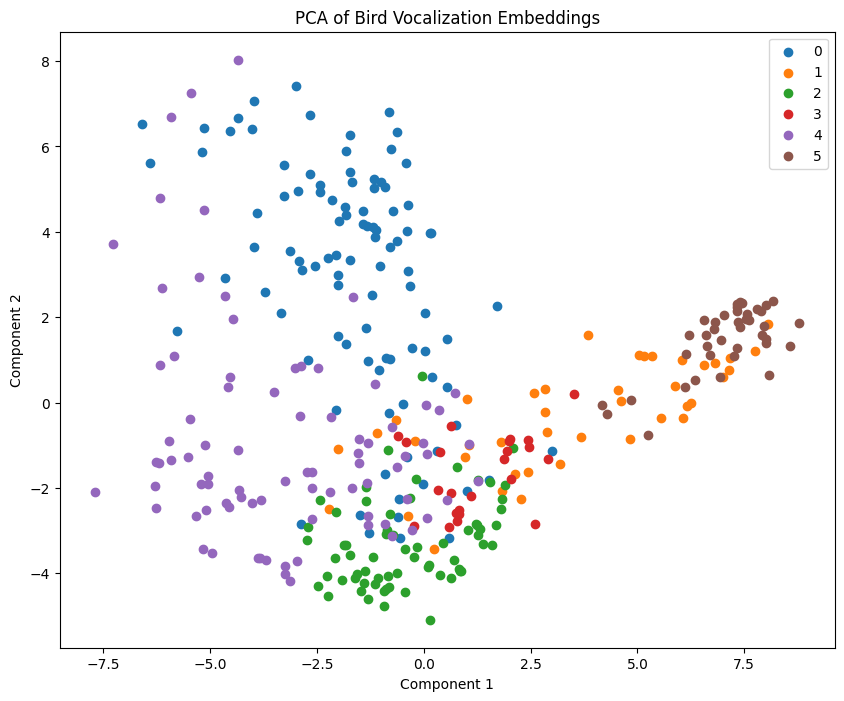

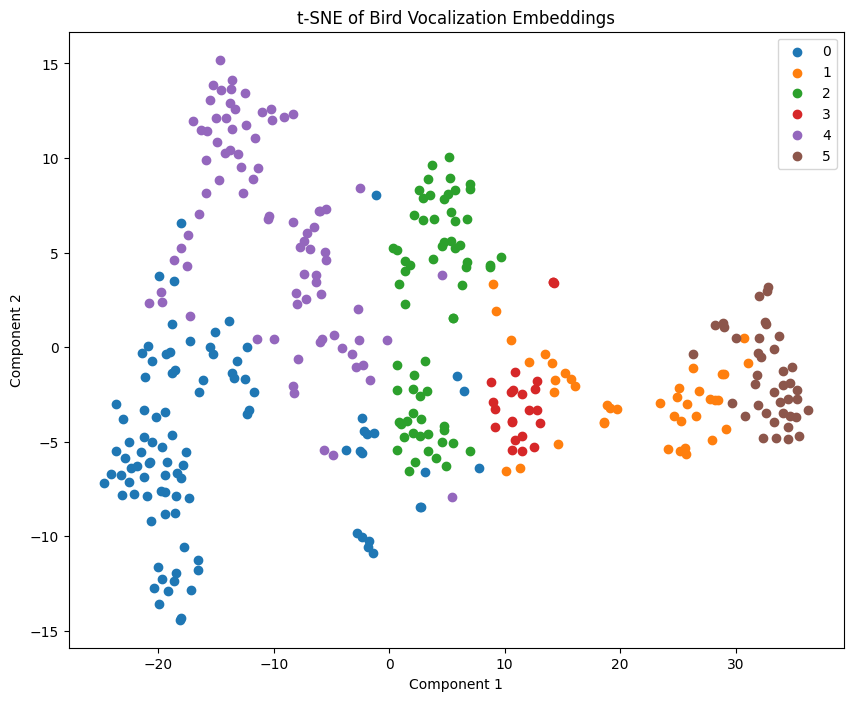

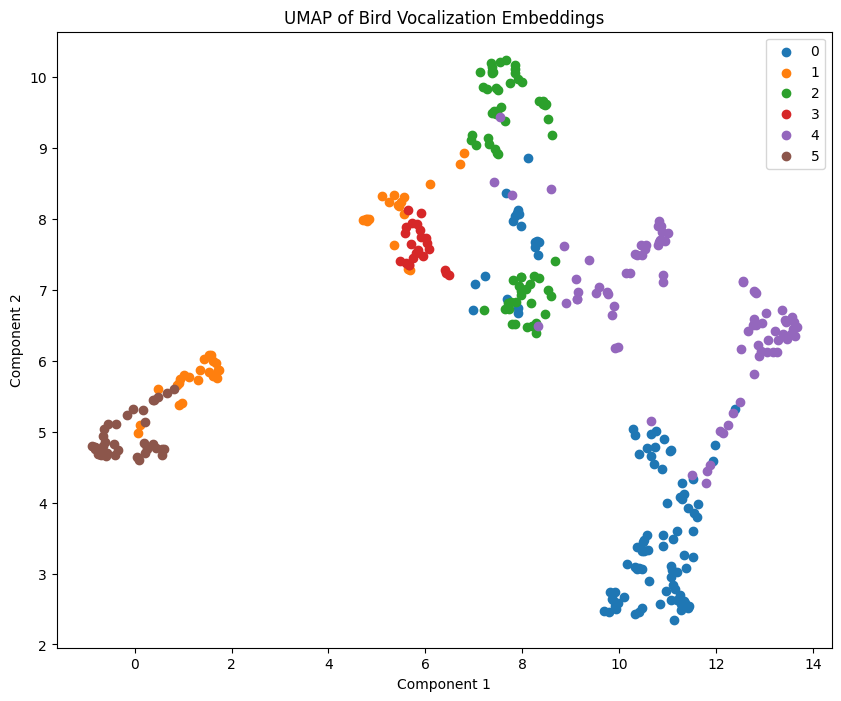

In [37]:
embeddings,labels = resnext_embeddings,labels
# Plot PCA
plot_reduction(embeddings, labels, 'PCA of Bird Vocalization Embeddings', method='pca')

# Plot t-SNE
plot_reduction(embeddings, labels, 't-SNE of Bird Vocalization Embeddings', method='tsne')

# Plot UMAP
plot_reduction(embeddings, labels, 'UMAP of Bird Vocalization Embeddings', method='umap')

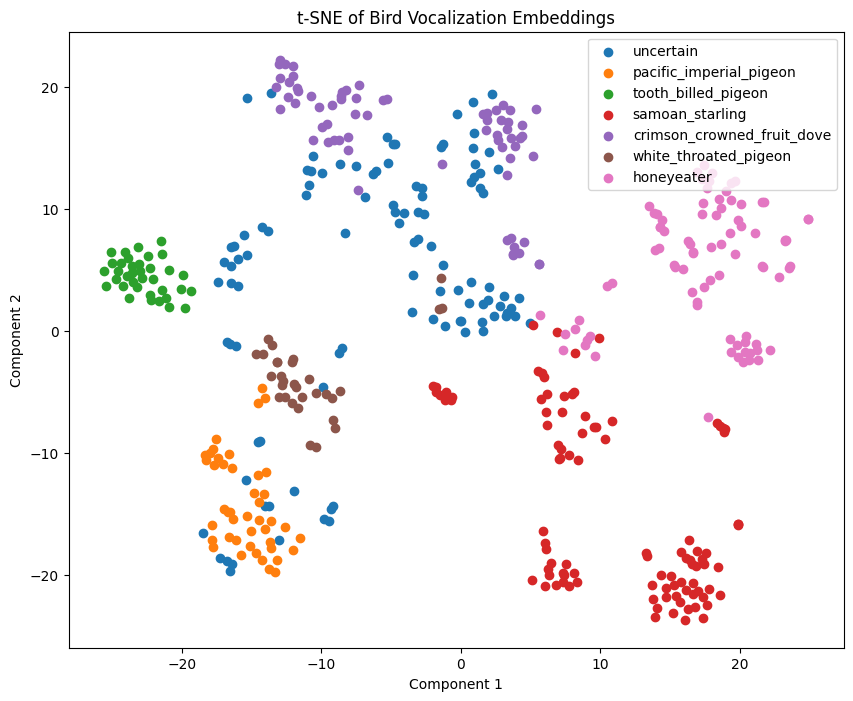

In [38]:
plot_reduction(np.vstack((birdnet_embeddings_train,birdnet_embeddings_test)), np.concatenate((birdnet_labels_train,birdnet_labels_test)), 't-SNE of Bird Vocalization Embeddings', method='tsne')

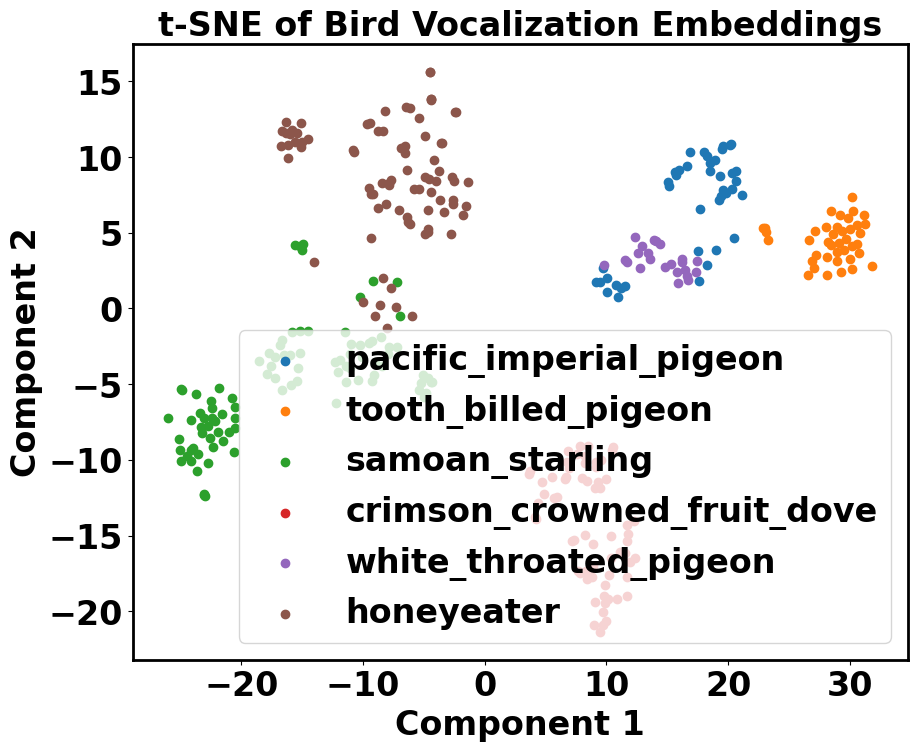

In [178]:
plot_reduction(birdnet_embeddings, birdnet_labels, 't-SNE of Bird Vocalization Embeddings', method='tsne')

For birdnet and tensorflow

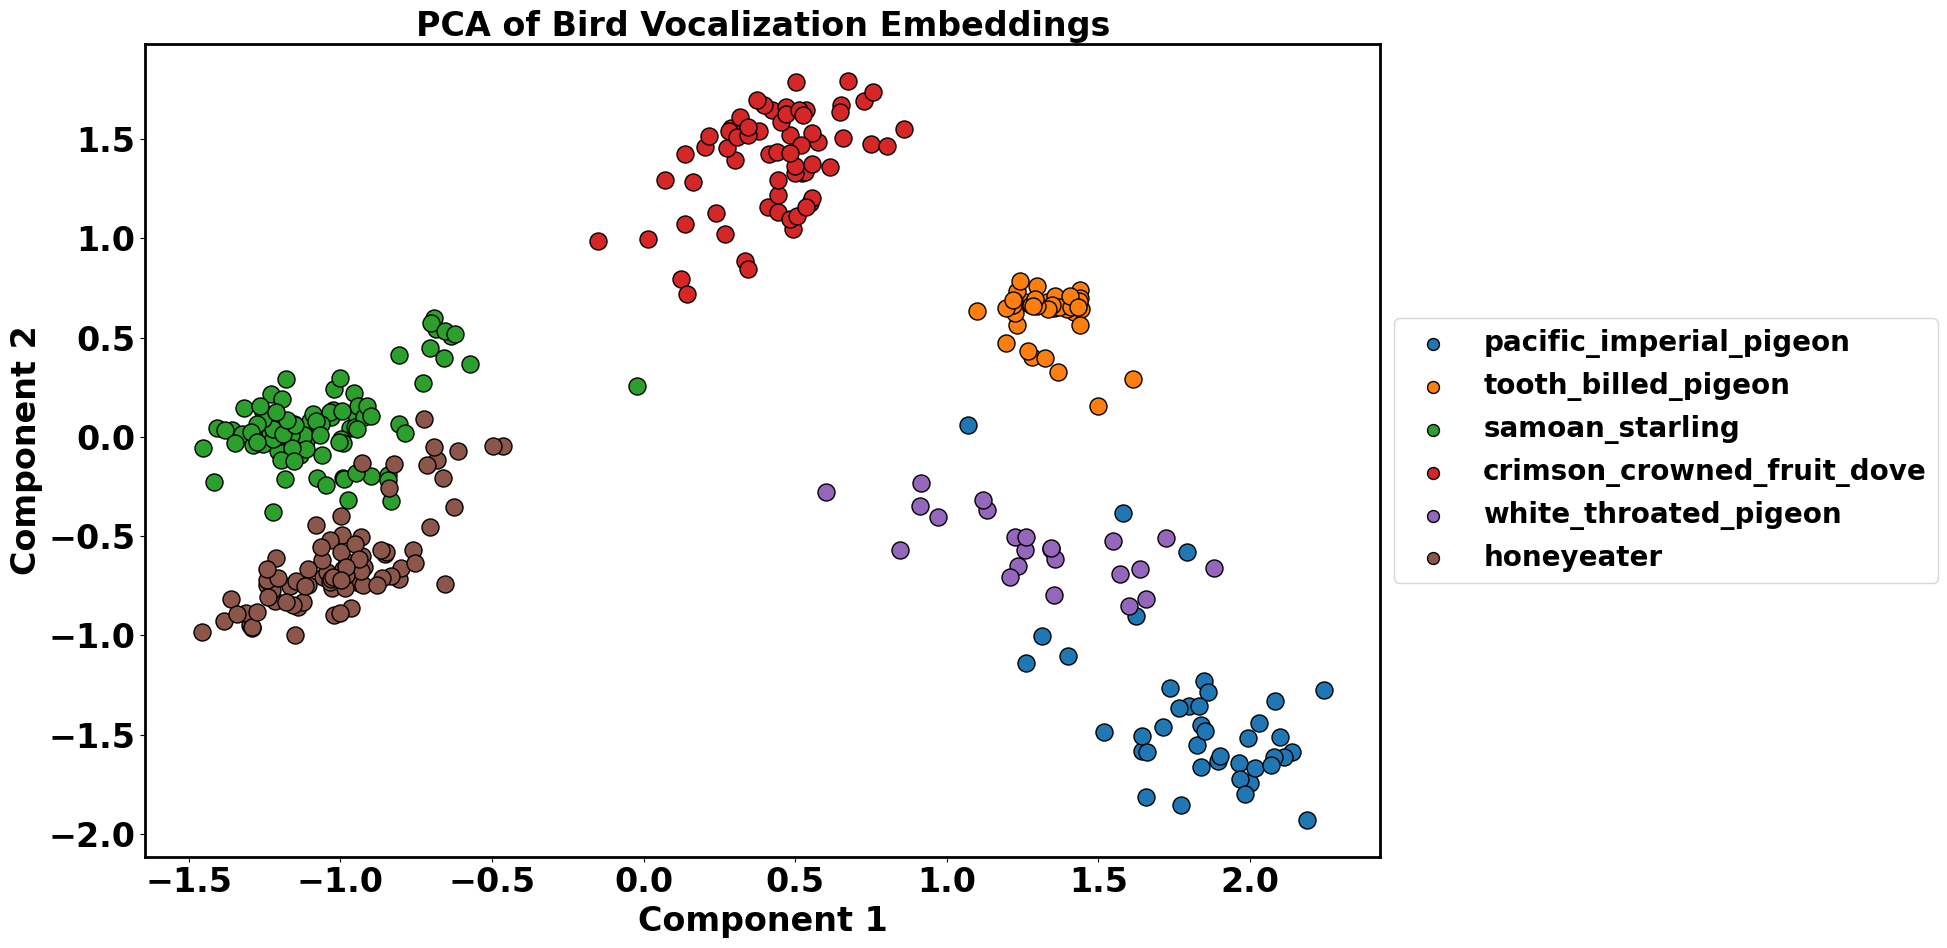

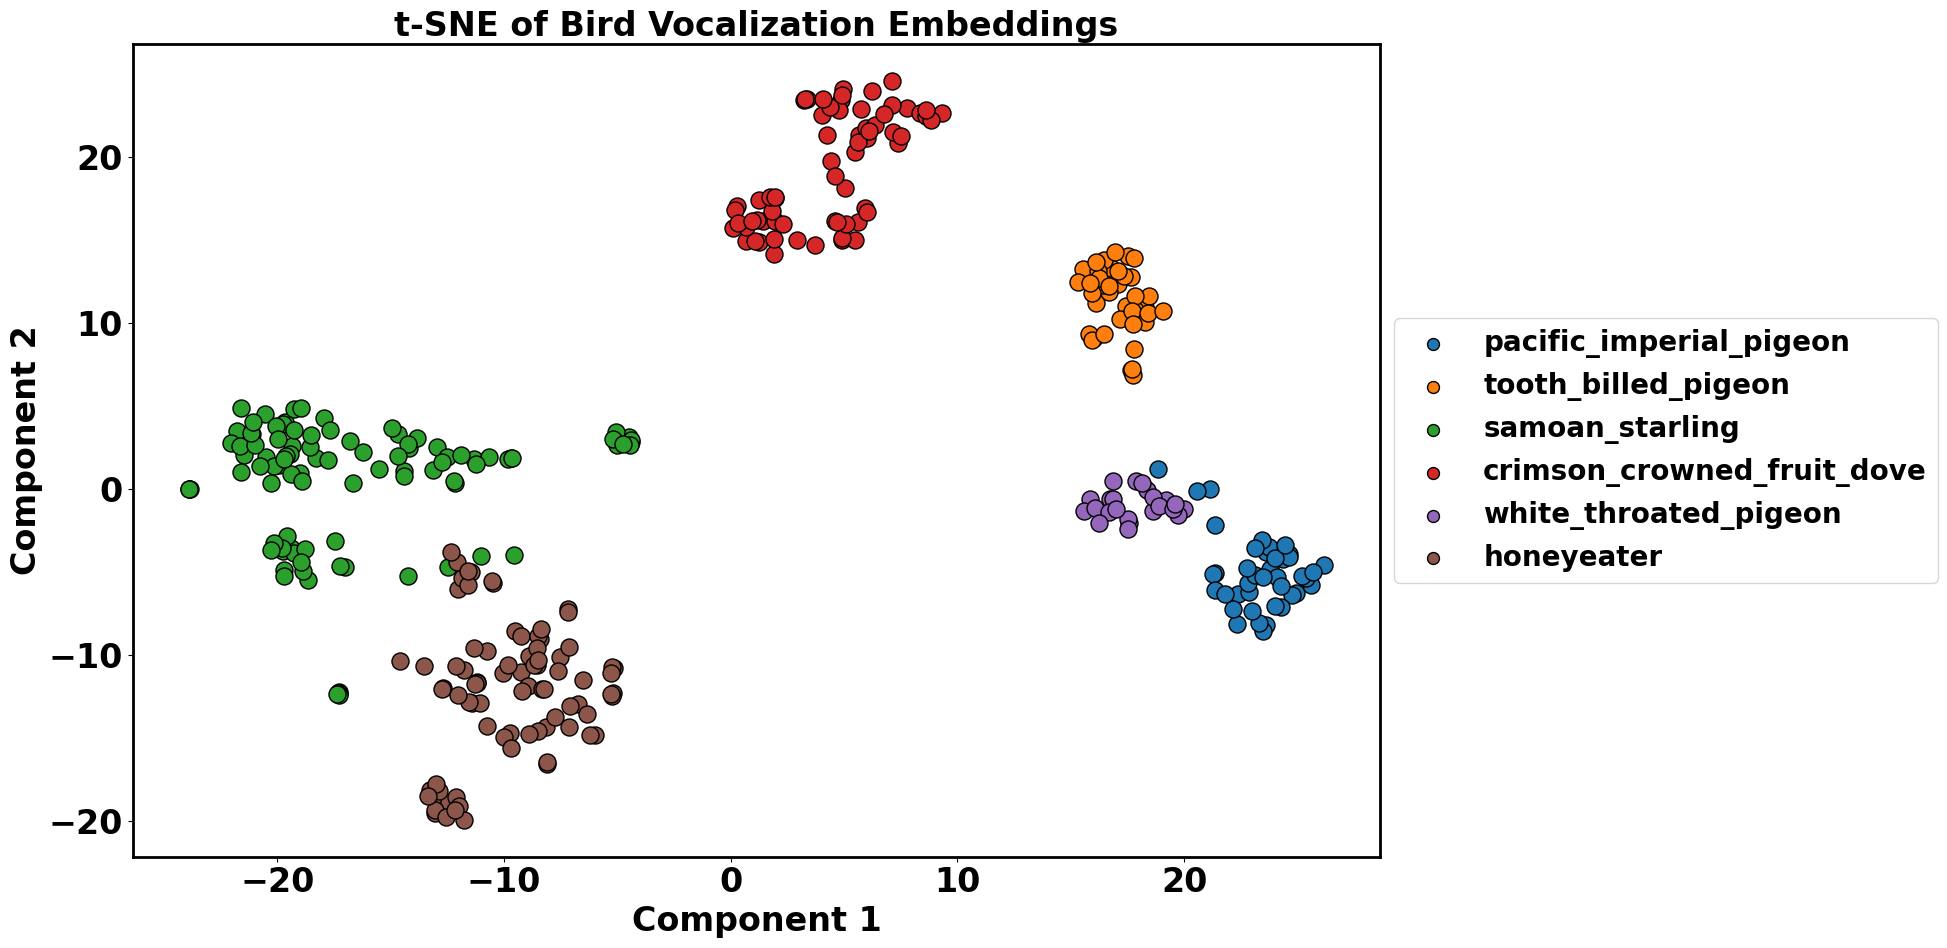

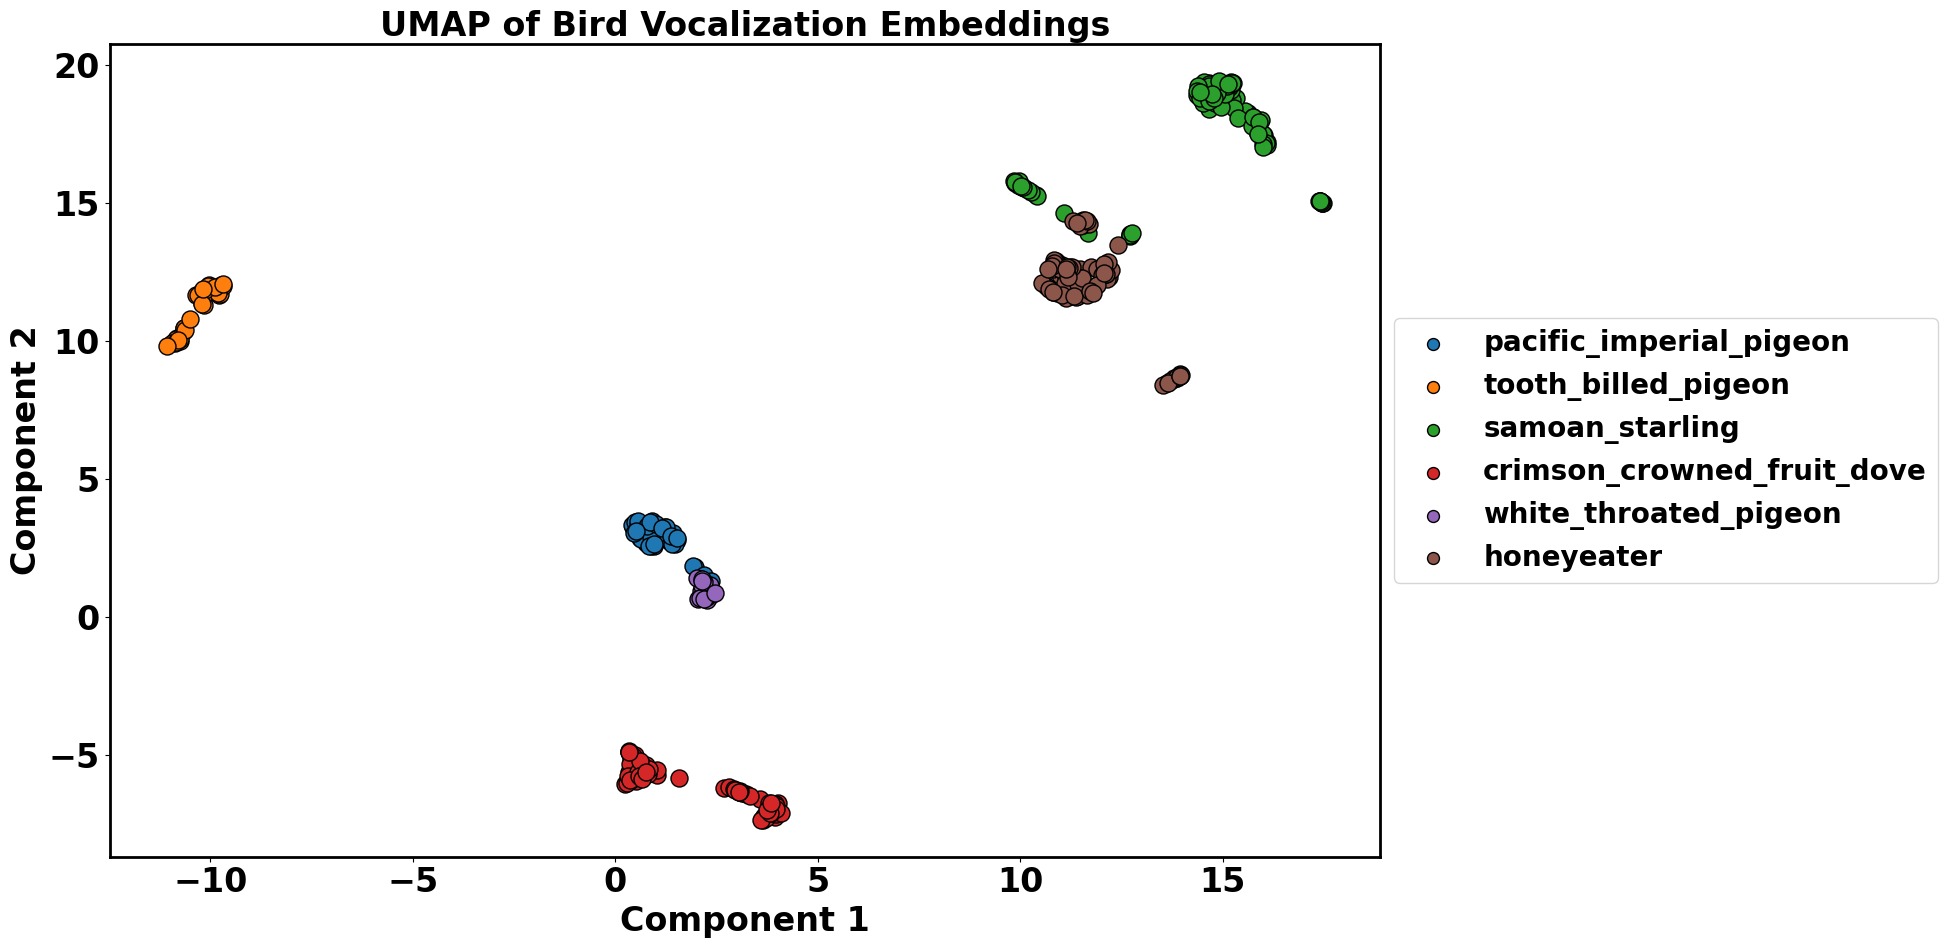

In [200]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import numpy as np

def plot_bvc_birdnet_reduction(embeddings, labels, title, method='pca',save_path = None):
    # Select the dimensionality reduction method
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2)
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'")

    # Reduce the dimensions of the embeddings
    reduced_components = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(20, 10))
    for label in set(labels):
        idx = np.array(labels) == label
        plt.scatter(reduced_components[idx, 0], reduced_components[idx, 1], 
                    label=label,s=150, edgecolor='black', alpha = 1)  # Add black edge to points
    
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', markerscale=0.7)  # Smaller legend and font
    plt.tight_layout()  # Adjust layout to fit legend
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150, pad_inches=0.1)    
    plt.show()
    
# Example usage:
# Plot PCA
plot_bvc_birdnet_reduction(bvc_embeddings, bvc_labels, 'PCA of Bird Vocalization Embeddings', method='pca')

# Plot t-SNE
plot_bvc_birdnet_reduction(bvc_embeddings, bvc_labels, 't-SNE of Bird Vocalization Embeddings', method='tsne')

# Plot UMAP
plot_bvc_birdnet_reduction(bvc_embeddings, bvc_labels, 'UMAP of Bird Vocalization Embeddings', method='umap')


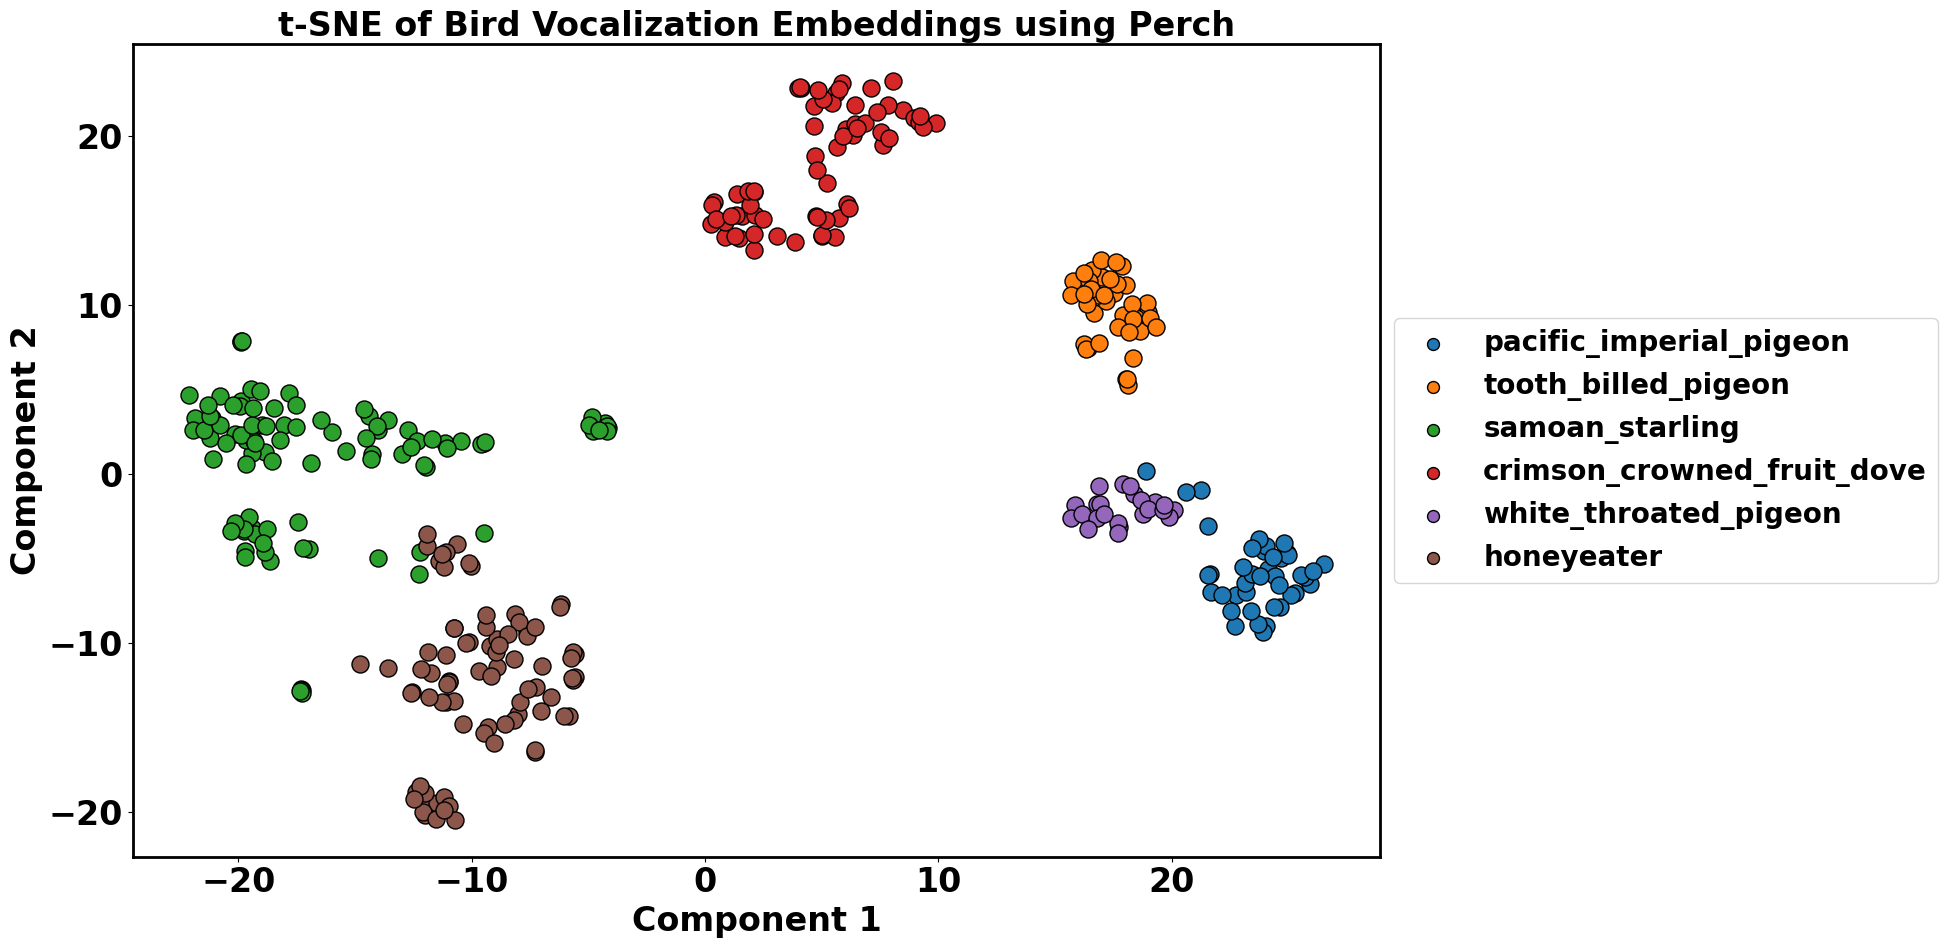

In [201]:
plot_bvc_birdnet_reduction(bvc_embeddings, bvc_labels, 't-SNE of Bird Vocalization Embeddings using Perch', method='tsne',save_path = './plots/tsne_perch.png')

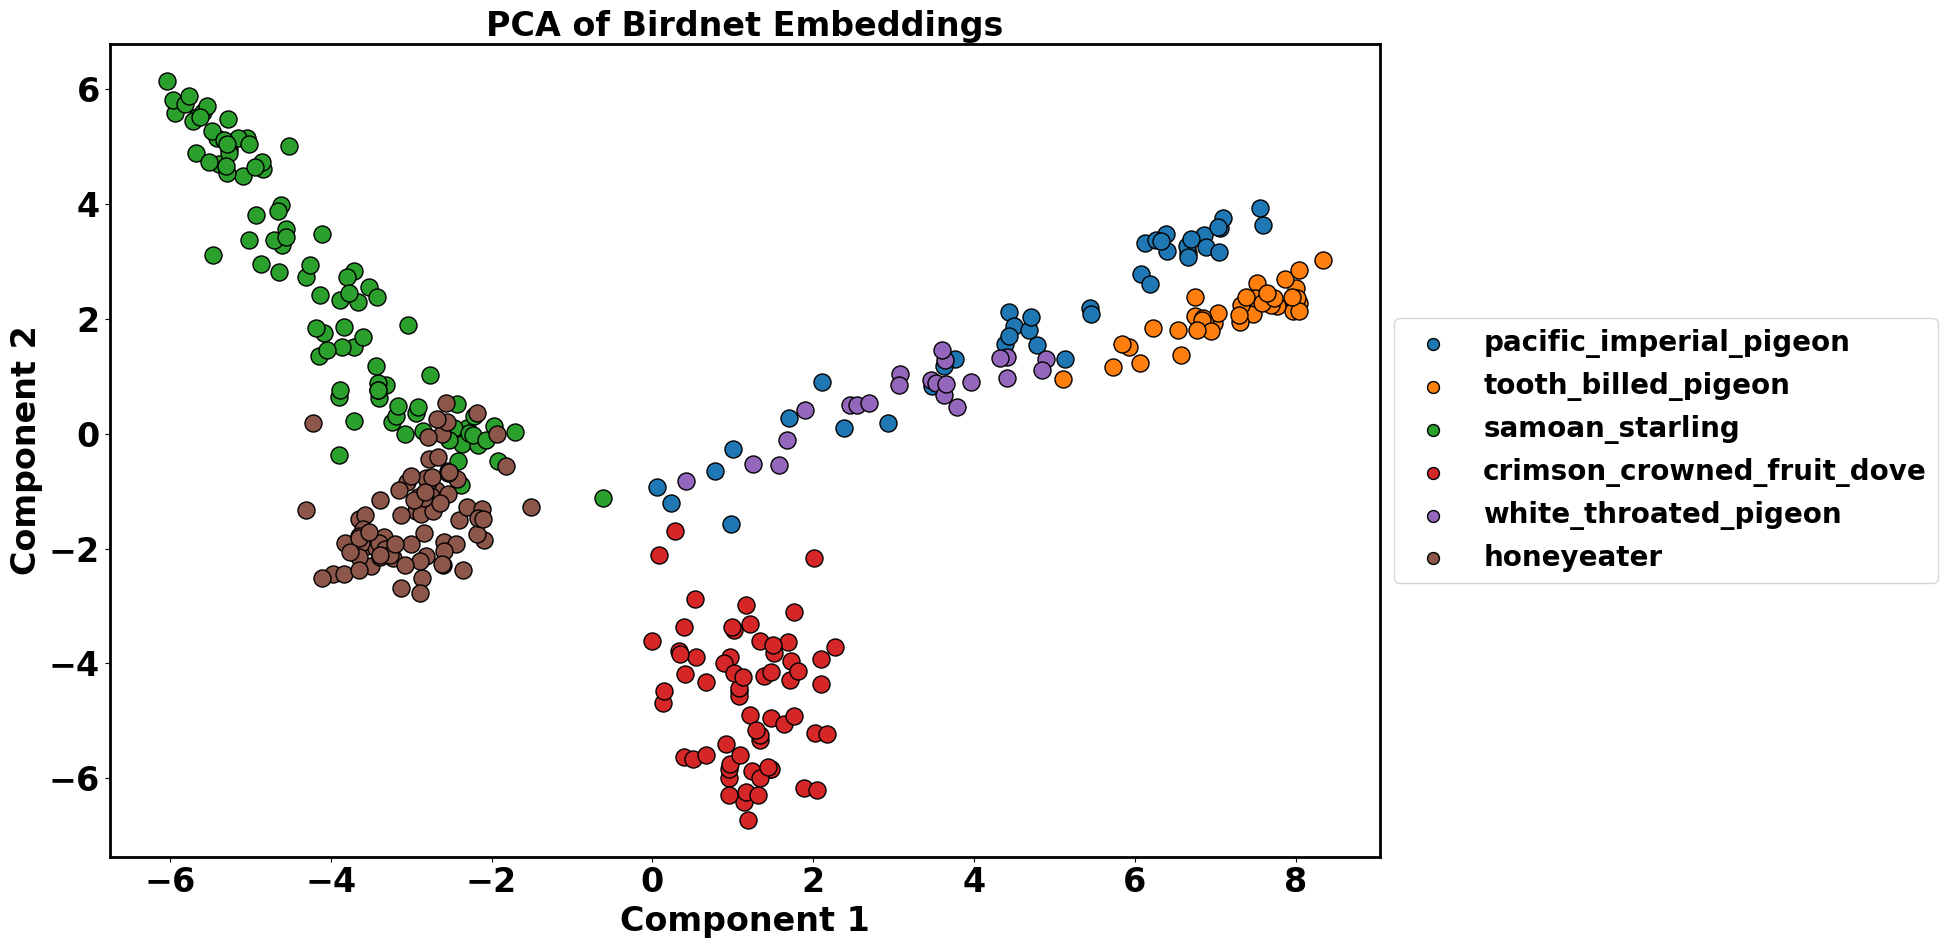

In [203]:
# Plot PCA
plot_bvc_birdnet_reduction(birdnet_embeddings, birdnet_labels, 'PCA of Birdnet Embeddings', method='pca')

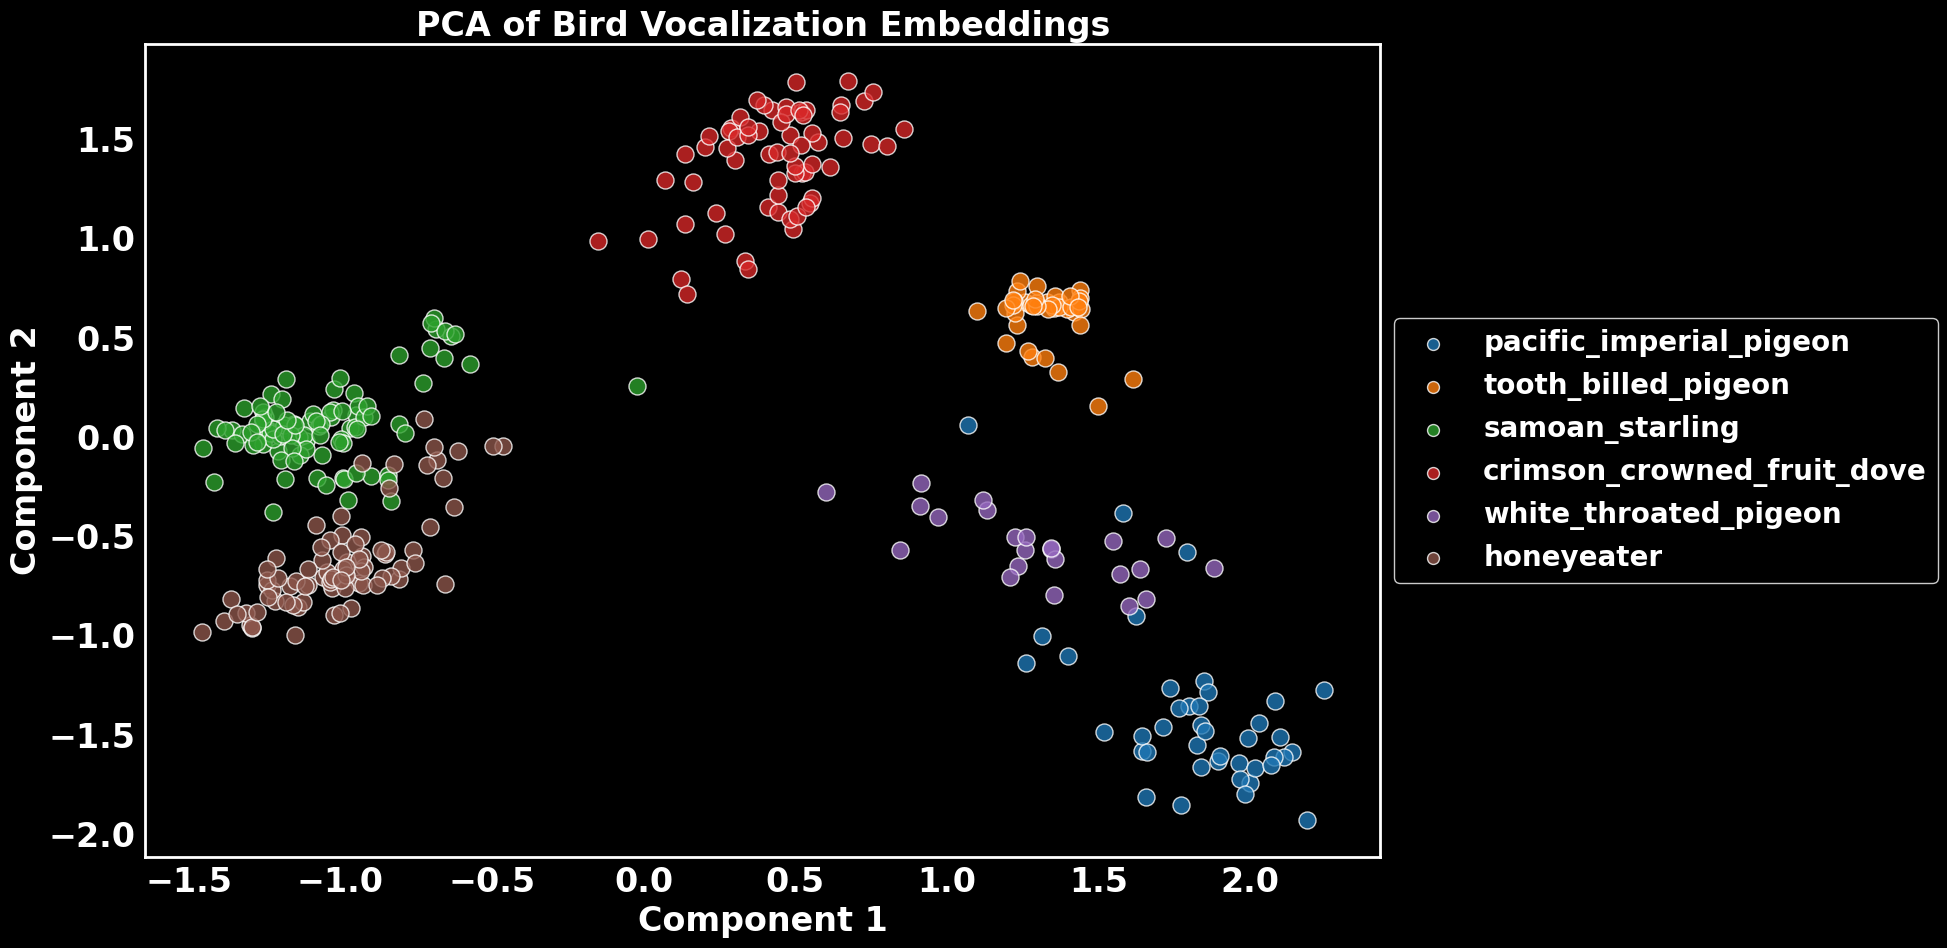

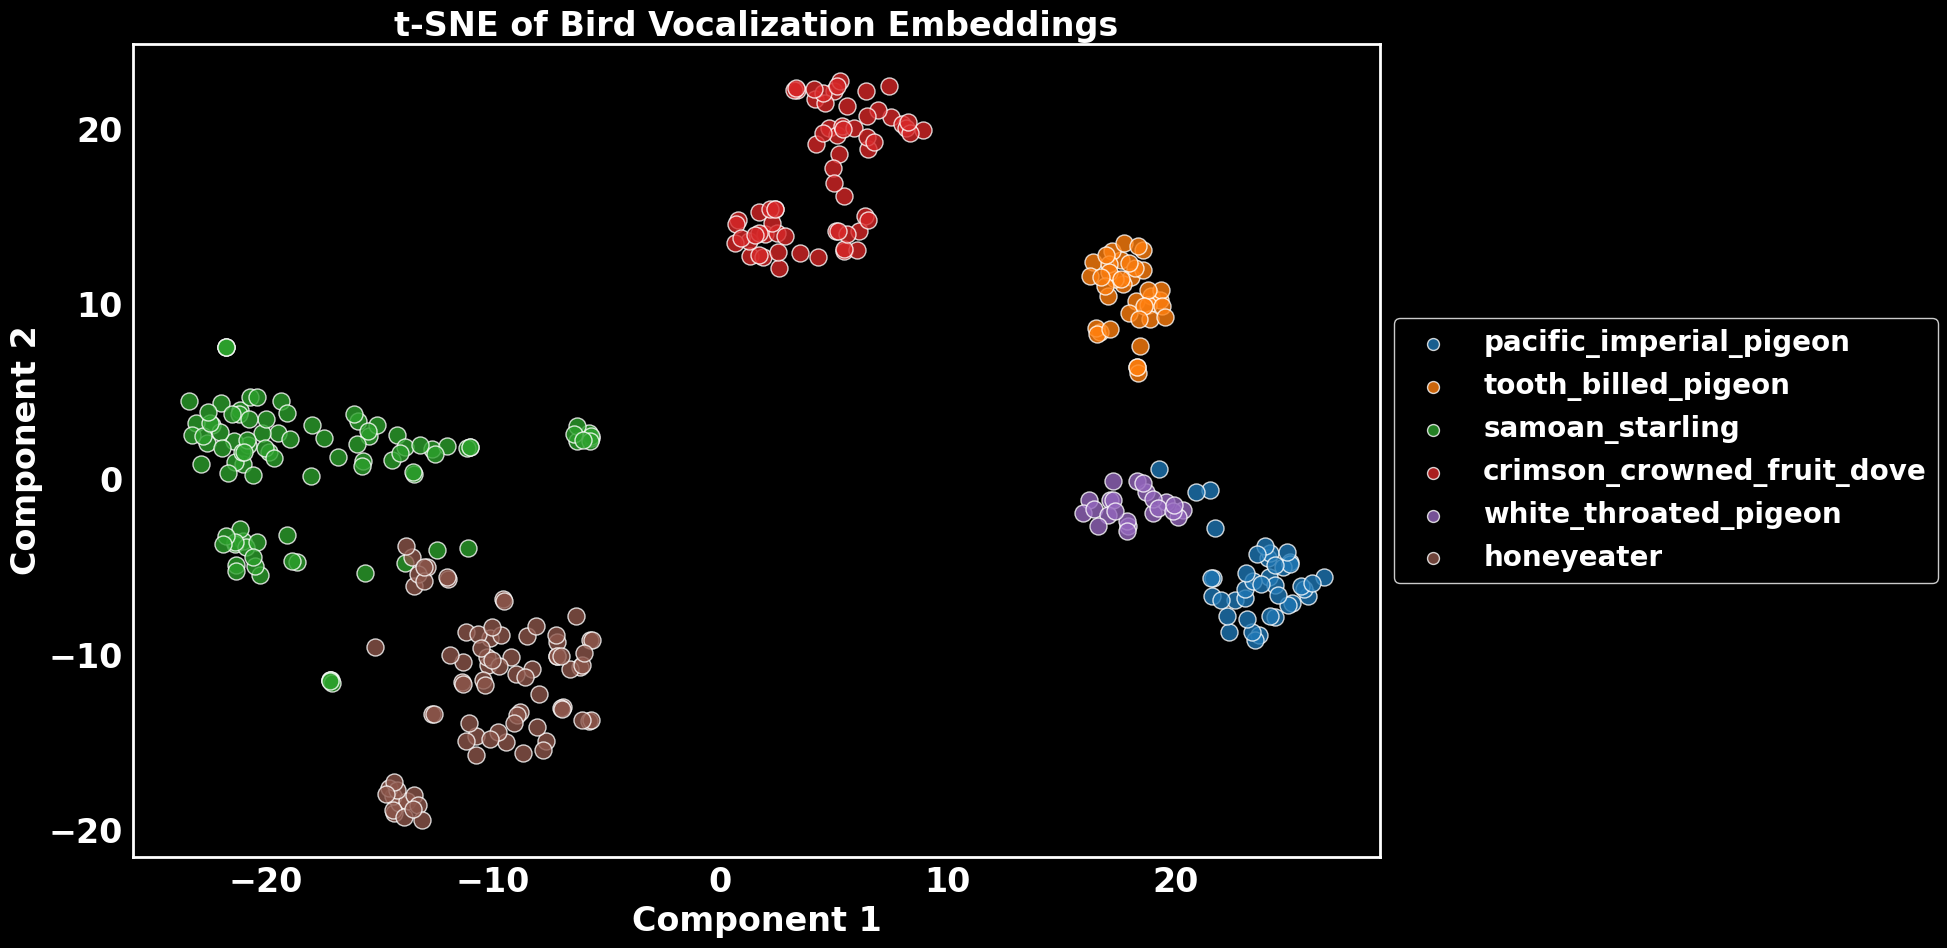

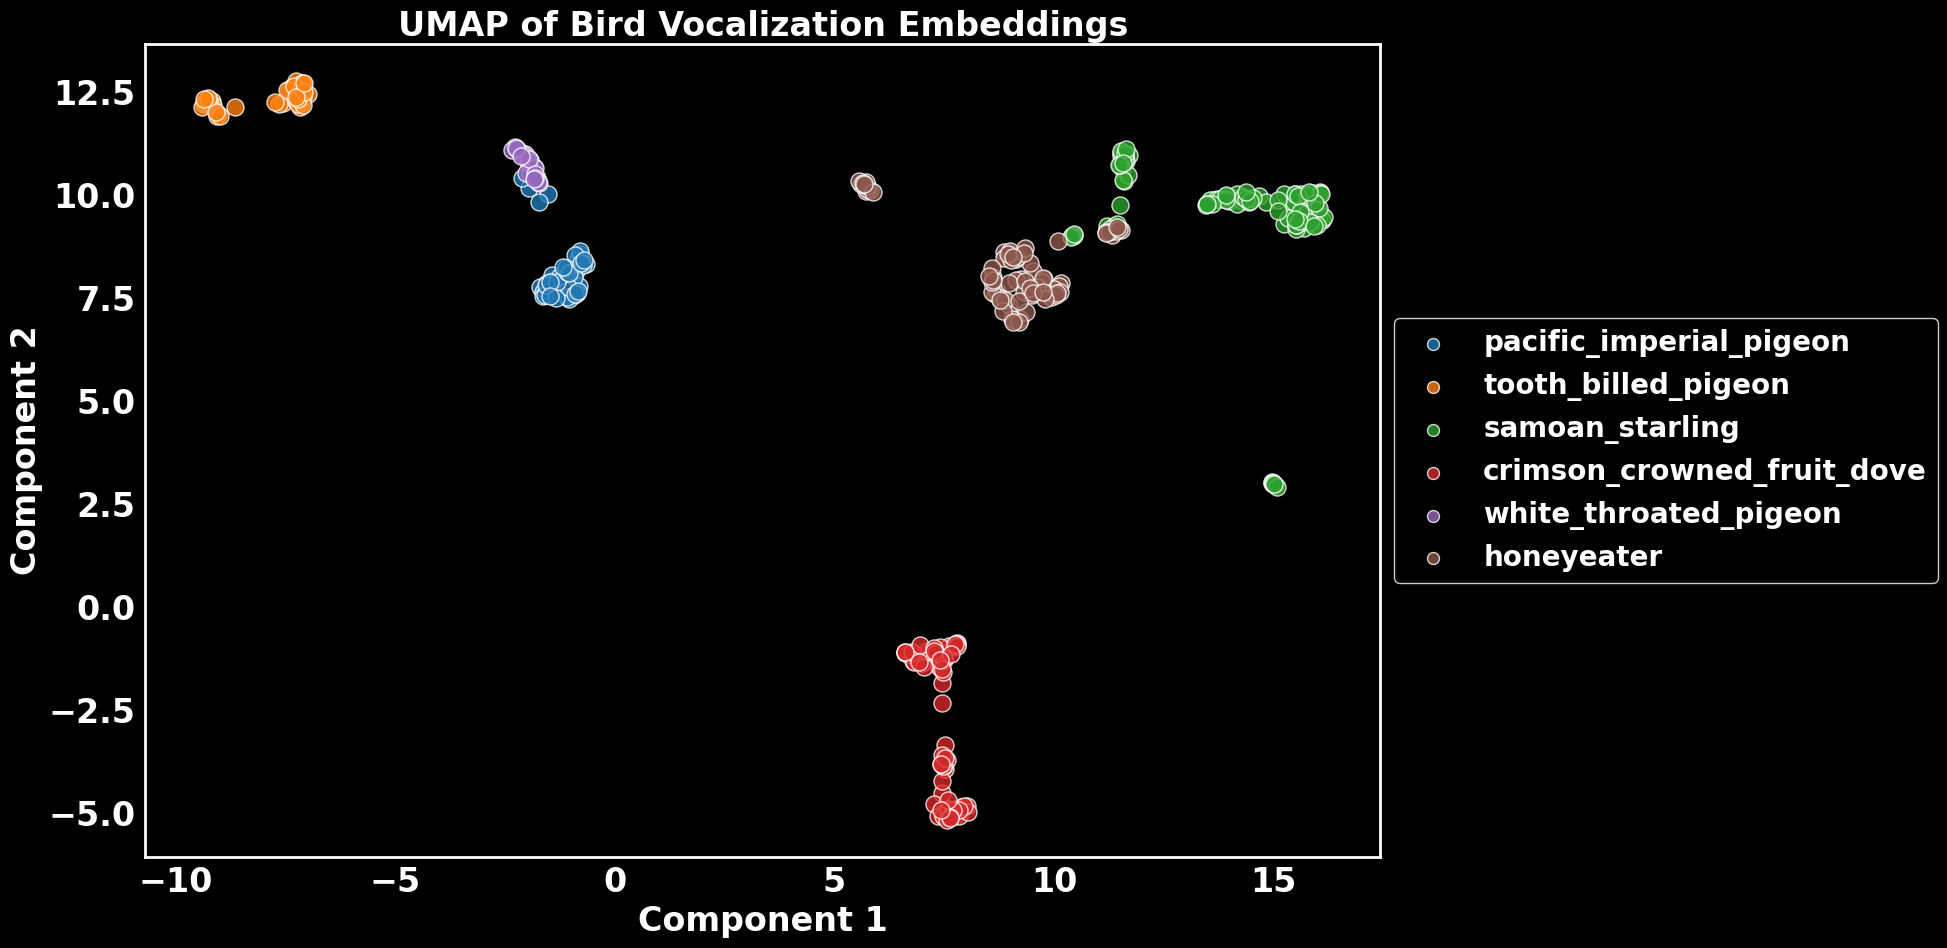

In [205]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import numpy as np

def plot_bvc_birdnet_reduction(embeddings, labels, title, method='pca', save_path=None):
    # Select the dimensionality reduction method
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2)
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'")

    # Reduce the dimensions of the embeddings
    reduced_components = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(20, 10), facecolor='black')  # Set figure background to black
    ax = plt.gca()
    ax.set_facecolor('black')  # Set axes background to black
    
    # Plot points
    for label in set(labels):
        idx = np.array(labels) == label
        plt.scatter(
            reduced_components[idx, 0], reduced_components[idx, 1], 
            label=label, s=150, edgecolor='white', alpha=0.8  # Use white edges for visibility
        )
    
    # Set plot title and labels
    plt.title(title, color='white')  # Title in white
    plt.xlabel('Component 1', color='white')  # X-axis label in white
    plt.ylabel('Component 2', color='white')  # Y-axis label in white
    
    # Set ticks color
    plt.xticks(color='white')  # X-axis ticks in white
    plt.yticks(color='white')  # Y-axis ticks in white
    
    # Set legend properties
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', markerscale=0.7, facecolor='black', edgecolor='white', labelcolor='white')
    
    # Add a white box around the plot area
    ax.spines['top'].set_edgecolor('white')
    ax.spines['right'].set_edgecolor('white')
    ax.spines['bottom'].set_edgecolor('white')
    ax.spines['left'].set_edgecolor('white')
    
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    
    plt.tight_layout()  # Adjust layout to fit legend
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150, pad_inches=0.1, facecolor='black')  # Save with black background
    
    plt.show()

# Example usage:
# Plot PCA
plot_bvc_birdnet_reduction(bvc_embeddings, bvc_labels, 'PCA of Bird Vocalization Embeddings', method='pca')

# Plot t-SNE
plot_bvc_birdnet_reduction(bvc_embeddings, bvc_labels, 't-SNE of Bird Vocalization Embeddings', method='tsne')

# Plot UMAP
plot_bvc_birdnet_reduction(bvc_embeddings, bvc_labels, 'UMAP of Bird Vocalization Embeddings', method='umap')


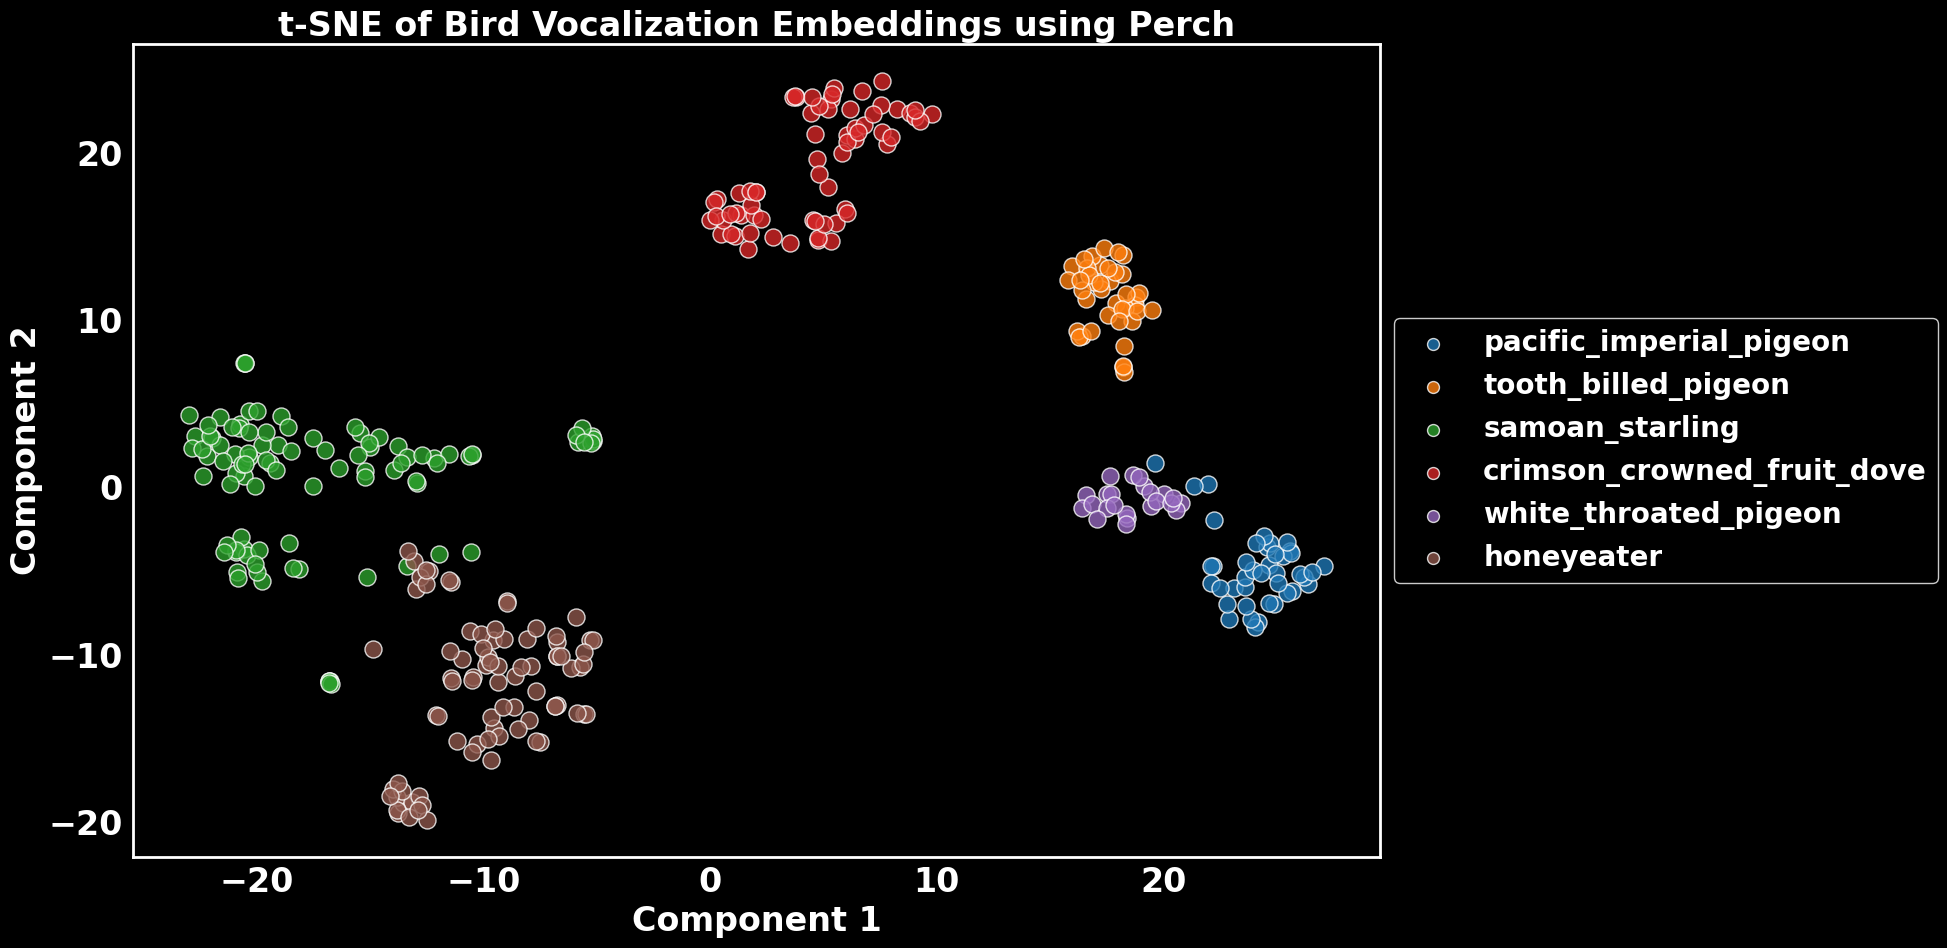

In [206]:
plot_bvc_birdnet_reduction(bvc_embeddings, bvc_labels, 't-SNE of Bird Vocalization Embeddings using Perch', method='tsne',save_path = './plots/tsne_perch.png')

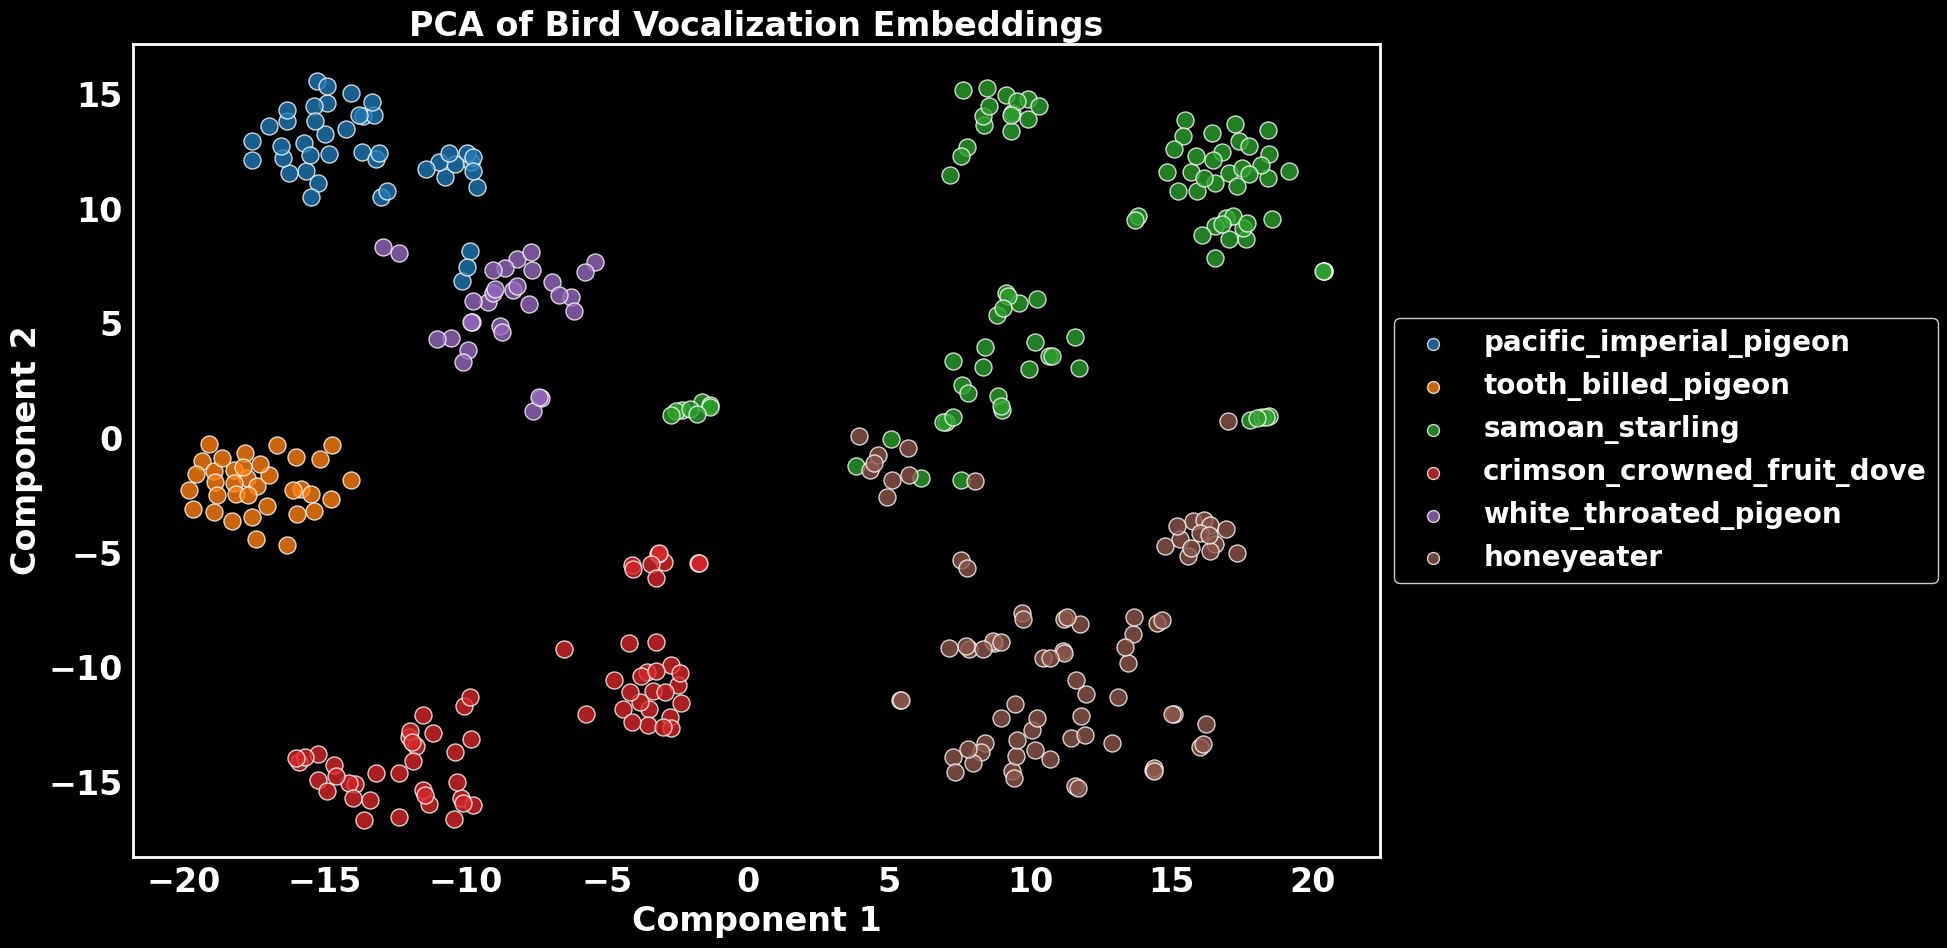

In [207]:
# Plot PCA
plot_bvc_birdnet_reduction(birdnet_embeddings_train, birdnet_labels_train, 'PCA of Bird Vocalization Embeddings', method='tsne')

In [ ]:
np.unique(birdnet_labels)

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA,TruncatedSVD
import itertools

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
from matplotlib.ticker import FormatStrFormatter


def plot_pairplot_pca(embeddings, labels, title, n_components=5, save_path=None, method='PCA'):
    # Set up consistent font size and weight across the plot using rcParams
    size = 20
    plt.rcParams.update({
        'font.size': size,
        'font.weight': 'bold',
        'axes.labelsize': size,
        'axes.labelweight': 'bold',
        'axes.titlesize': size,
        'axes.titleweight': 'bold',
        'xtick.labelsize': size,
        'xtick.color': 'black',
        'ytick.labelsize': size,
        'ytick.color': 'black',
        'axes.linewidth': 2,  # Make axis borders bold
    })

    # Define label mapping
    label_mapping = {
        'crimson_crowned_fruit_dove': 'Crimson-crowned fruit dove',
        'honeyeater': 'Polynesian wattled honeyeater',
        'pacific_imperial_pigeon': 'Pacific imperial pigeon',
        'samoan_starling': 'Samoan starling',
        'tooth_billed_pigeon': 'Tooth-billed pigeon',
        'white_throated_pigeon': 'White-throated pigeon'
    }
    
    # Rename labels
    renamed_labels = [label_mapping.get(label, label) for label in labels]
    
    # Perform PCA or TruncatedSVD
    if method == 'PCA':
        pca = PCA(n_components=n_components)
    else:
        pca = TruncatedSVD(n_components=n_components)
    pca_components = pca.fit_transform(embeddings)
    
    # Create a DataFrame with PCA components and renamed labels
    df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(n_components)])
    df['label'] = renamed_labels
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(n_components, n_components, figsize=(3.8*n_components, 3.8*n_components))
    
    # Plot lower triangle of pairplot
    for i in range(n_components):
        for j in range(n_components):
            if i > j:  # This ensures we only plot the lower triangle
                sns.scatterplot(
                    data=df, 
                    x=f'PC{j+1}', 
                    y=f'PC{i+1}', 
                    hue='label', 
                    ax=axes[i, j],
                    s=100,  # Set the size of scatter points
                    edgecolor='black'  # Add a black edge to the points
                )
                
                # Only set xlabel for the bottom row
                if i == n_components - 1:
                    axes[i, j].set_xlabel(f'PC{j+1}')
                else:
                    axes[i, j].set_xlabel('')
                
                # Only set ylabel for the leftmost column
                if j == 0:
                    axes[i, j].set_ylabel(f'PC{i+1}')
                else:
                    axes[i, j].set_ylabel('')
                
                # Remove tick labels except for leftmost column and bottom row
                if i != n_components - 1:
                    axes[i, j].set_xticklabels([])
                if j != 0:
                    axes[i, j].set_yticklabels([])
                    
            else:
                axes[i, j].axis('off')  # Turn off axes for upper triangle and diagonal
            # Ensure consistent formatting for tick labels
            axes[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            axes[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    # Adjust font sizes and axis borders
    for ax in axes.flat:
        ax.tick_params(labelsize=size)
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    
    # Add a single legend
    handles, labels = axes[-1, 0].get_legend_handles_labels()
    fig.legend(
        handles, 
        labels, 
        loc='upper center', 
        fontsize=size, 
        bbox_to_anchor=(0.5, 0.75), 
        ncol=1,
        borderaxespad=0.1,  # Space between the legend and the axes
        borderpad=0.2,      # Padding inside the legend box
        handletextpad=0.2   # Space between the legend symbol and the text
    )

    # Set the title
    plt.suptitle(title, y=0.8, fontsize=size + 2, fontweight='bold')
    
    # Adjust layout to minimize whitespace and shift the triangle plot up
    plt.tight_layout()
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.98, left=0.07, wspace=0.02, hspace=0.02)

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150, pad_inches=0.1)
    plt.show()


In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
from matplotlib.ticker import FormatStrFormatter

def plot_pairplot_pca(embeddings, labels, title, n_components=5, save_path=None, method='PCA'):
    # Set up consistent font size and weight across the plot using rcParams
    size = 24
    plt.rcParams.update({
        'font.size': size,
        'font.weight': 'bold',
        'axes.labelsize': size,
        'axes.labelweight': 'bold',
        'axes.titlesize': size,
        'axes.titleweight': 'bold',
        'xtick.labelsize': size,
        'xtick.color': 'black',
        'ytick.labelsize': size,
        'ytick.color': 'black',
        'axes.linewidth': 2,  # Make axis borders bold
    })

    # Define label mapping
    label_mapping = {
        'crimson_crowned_fruit_dove': 'Crimson-crowned fruit dove',
        'honeyeater': 'Polynesian wattled honeyeater',
        'pacific_imperial_pigeon': 'Pacific imperial pigeon',
        'samoan_starling': 'Samoan starling',
        'tooth_billed_pigeon': 'Tooth-billed pigeon',
        'white_throated_pigeon': 'White-throated pigeon'
    }
    
    # Rename labels
    renamed_labels = [label_mapping.get(label, label) for label in labels]
    
    # Perform PCA or TruncatedSVD
    if method == 'PCA':
        pca = PCA(n_components=n_components)
    else:
        pca = TruncatedSVD(n_components=n_components)
    pca_components = pca.fit_transform(embeddings)
    
    # Create a DataFrame with PCA components and renamed labels
    df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(n_components)])
    df['label'] = renamed_labels
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(n_components, n_components, figsize=(3.8*n_components, 3.8*n_components))
    
    # Plot lower triangle of pairplot
    for i in range(n_components):
        for j in range(n_components):
            if i > j:  # This ensures we only plot the lower triangle
                sns.scatterplot(
                    data=df, 
                    x=f'PC{j+1}', 
                    y=f'PC{i+1}', 
                    hue='label', 
                    ax=axes[i, j],
                    s=100,  # Set the size of scatter points
                    edgecolor='black'  # Add a black edge to the points
                )
                
                # Only set xlabel for the bottom row
                if i == n_components - 1:
                    axes[i, j].set_xlabel(f'PC{j+1}')
                else:
                    axes[i, j].set_xlabel('')
                
                # Only set ylabel for the leftmost column
                if j == 0:
                    axes[i, j].set_ylabel(f'PC{i+1}')
                else:
                    axes[i, j].set_ylabel('')
                    axes[i, j].tick_params(left=False, labelleft=False)  # Remove y-axis ticks and labels for inner boxes
                
                # Remove tick labels except for leftmost column and bottom row
                if i != n_components - 1:
                    axes[i, j].set_xticklabels([])
                    
            else:
                axes[i, j].axis('off')  # Turn off axes for upper triangle and diagonal
            
            # Ensure consistent formatting for tick labels
            axes[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            axes[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    # Adjust font sizes and axis borders
    for ax in axes.flat:
        ax.tick_params(labelsize=size)
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    
    # Add a single legend
    handles, labels = axes[-1, 0].get_legend_handles_labels()
    fig.legend(
        handles, 
        labels, 
        loc='upper center', 
        fontsize=size, 
        bbox_to_anchor=(0.5, 0.75), 
        ncol=1,
        borderaxespad=0.1,  # Space between the legend and the axes
        borderpad=0.2,      # Padding inside the legend box
        handletextpad=0.2   # Space between the legend symbol and the text
    )

    # Set the title
    plt.suptitle(title, y=0.8, fontsize=size + 2, fontweight='bold')
    
    # Adjust layout to minimize whitespace and shift the triangle plot up
    plt.tight_layout()
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.98, left=0.07, wspace=0.02, hspace=0.02)

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150, pad_inches=0.1)
    plt.show()

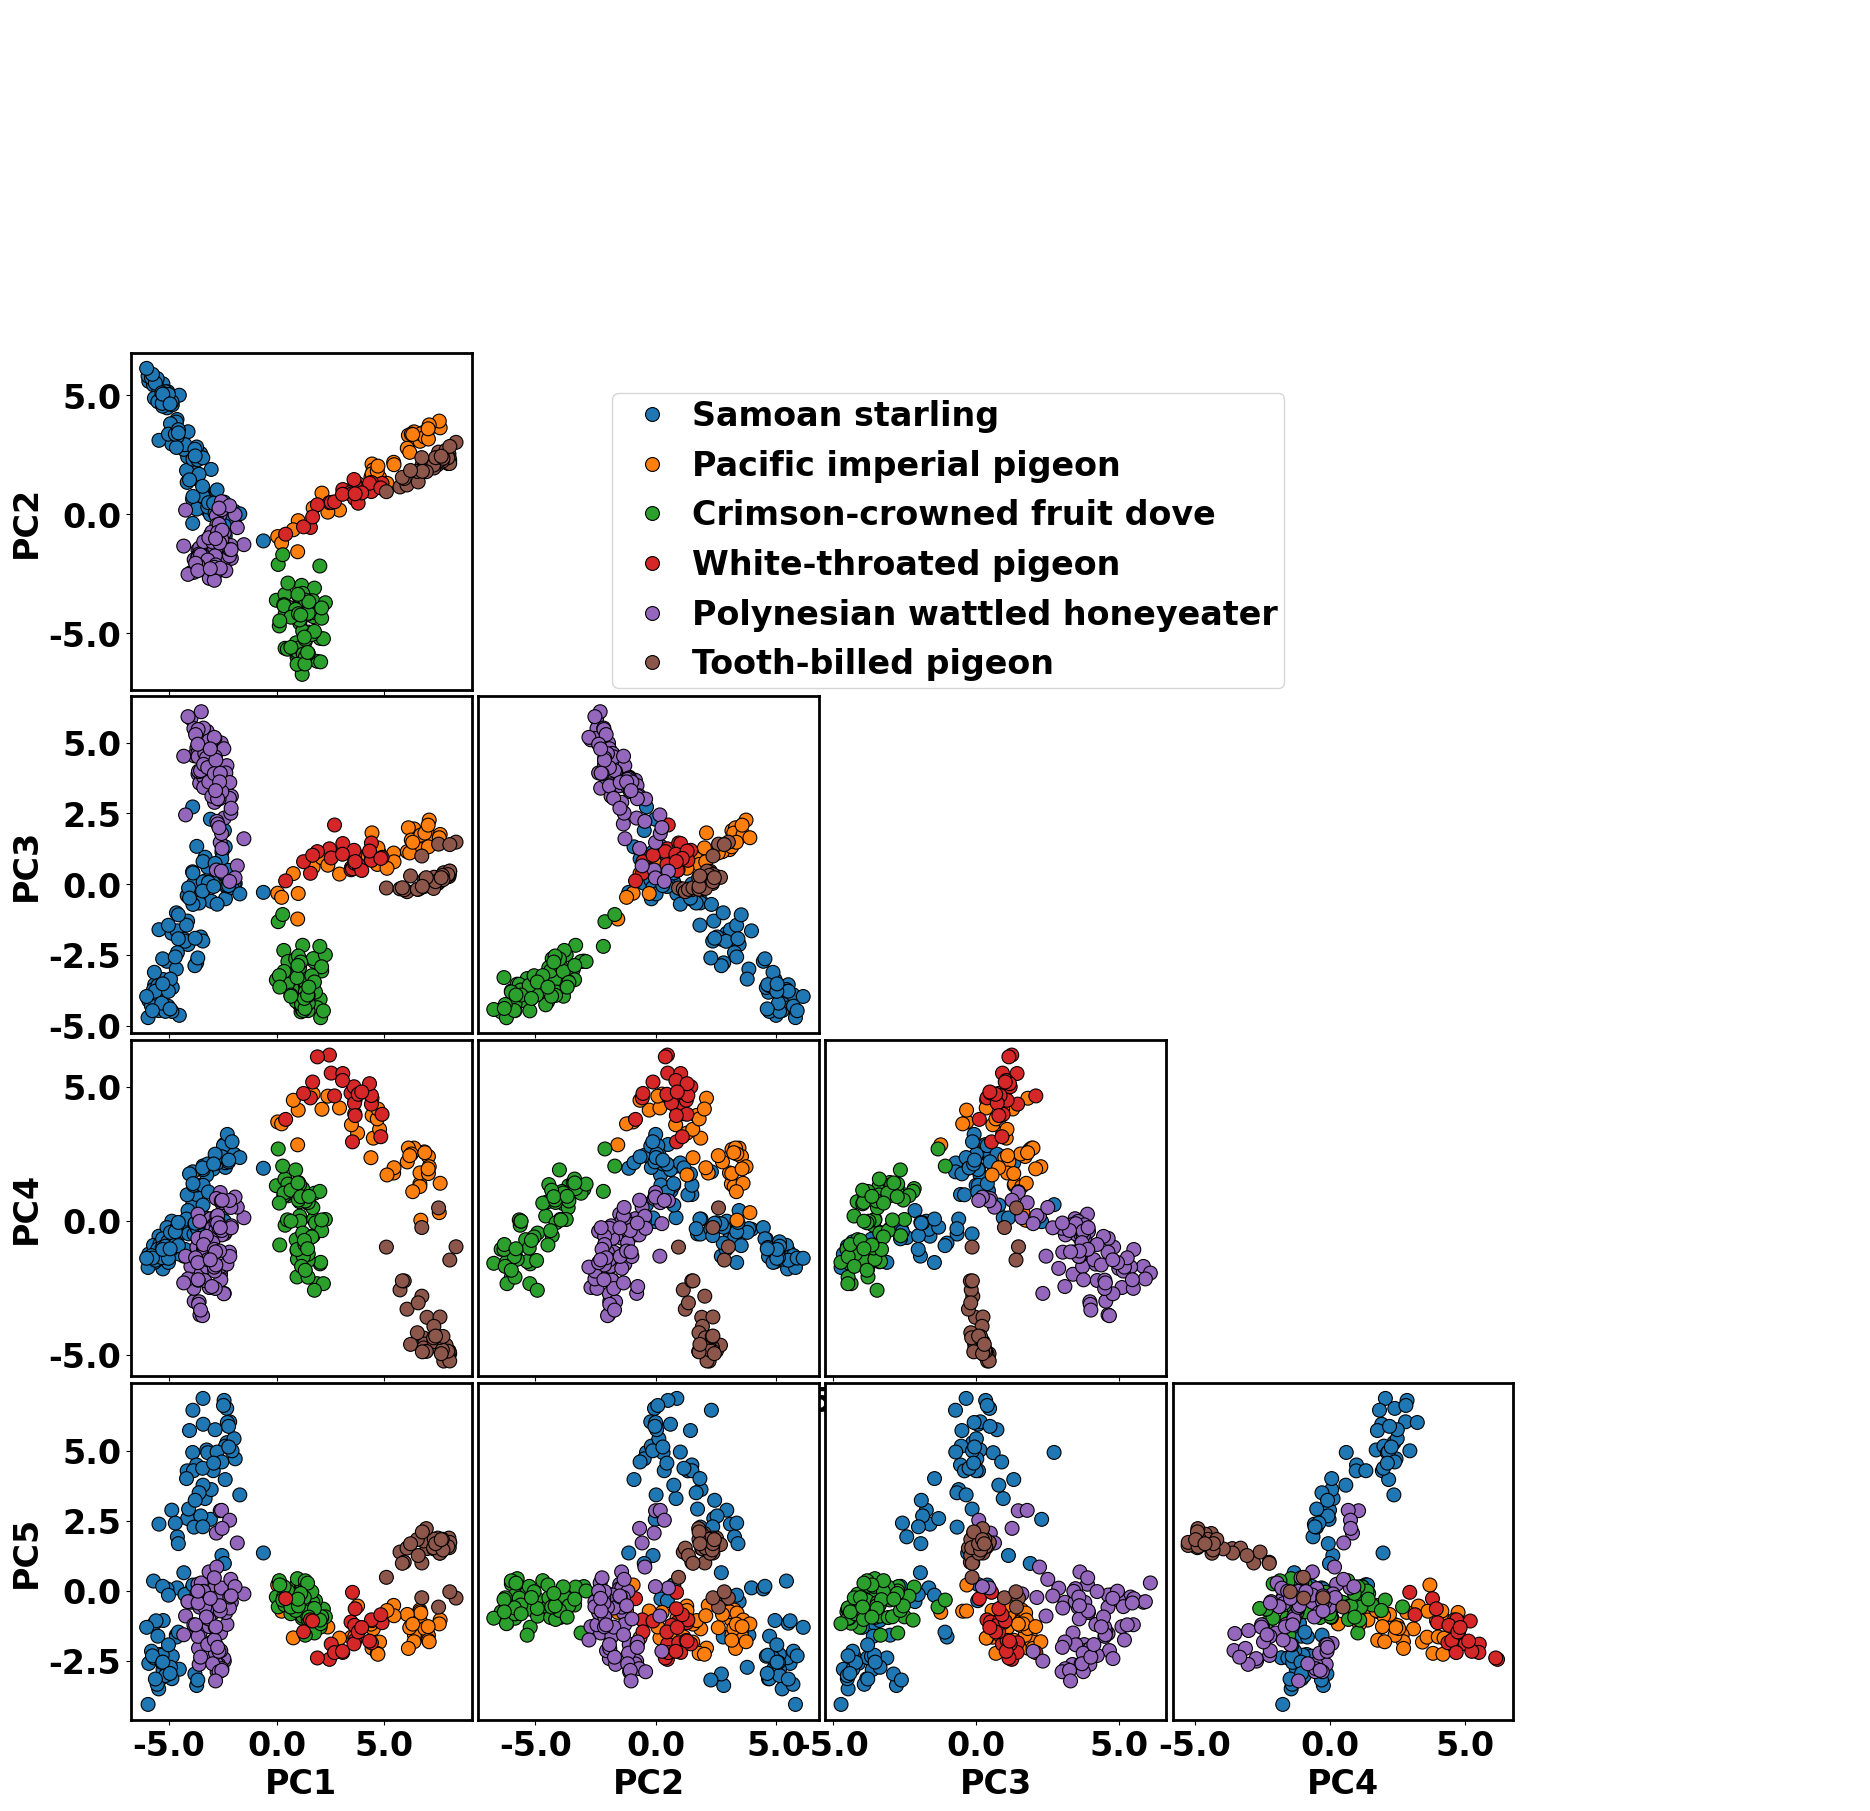

In [176]:
plot_pairplot_pca(birdnet_embeddings, birdnet_labels, '', save_path='./plots/top_5_birdnet.png')

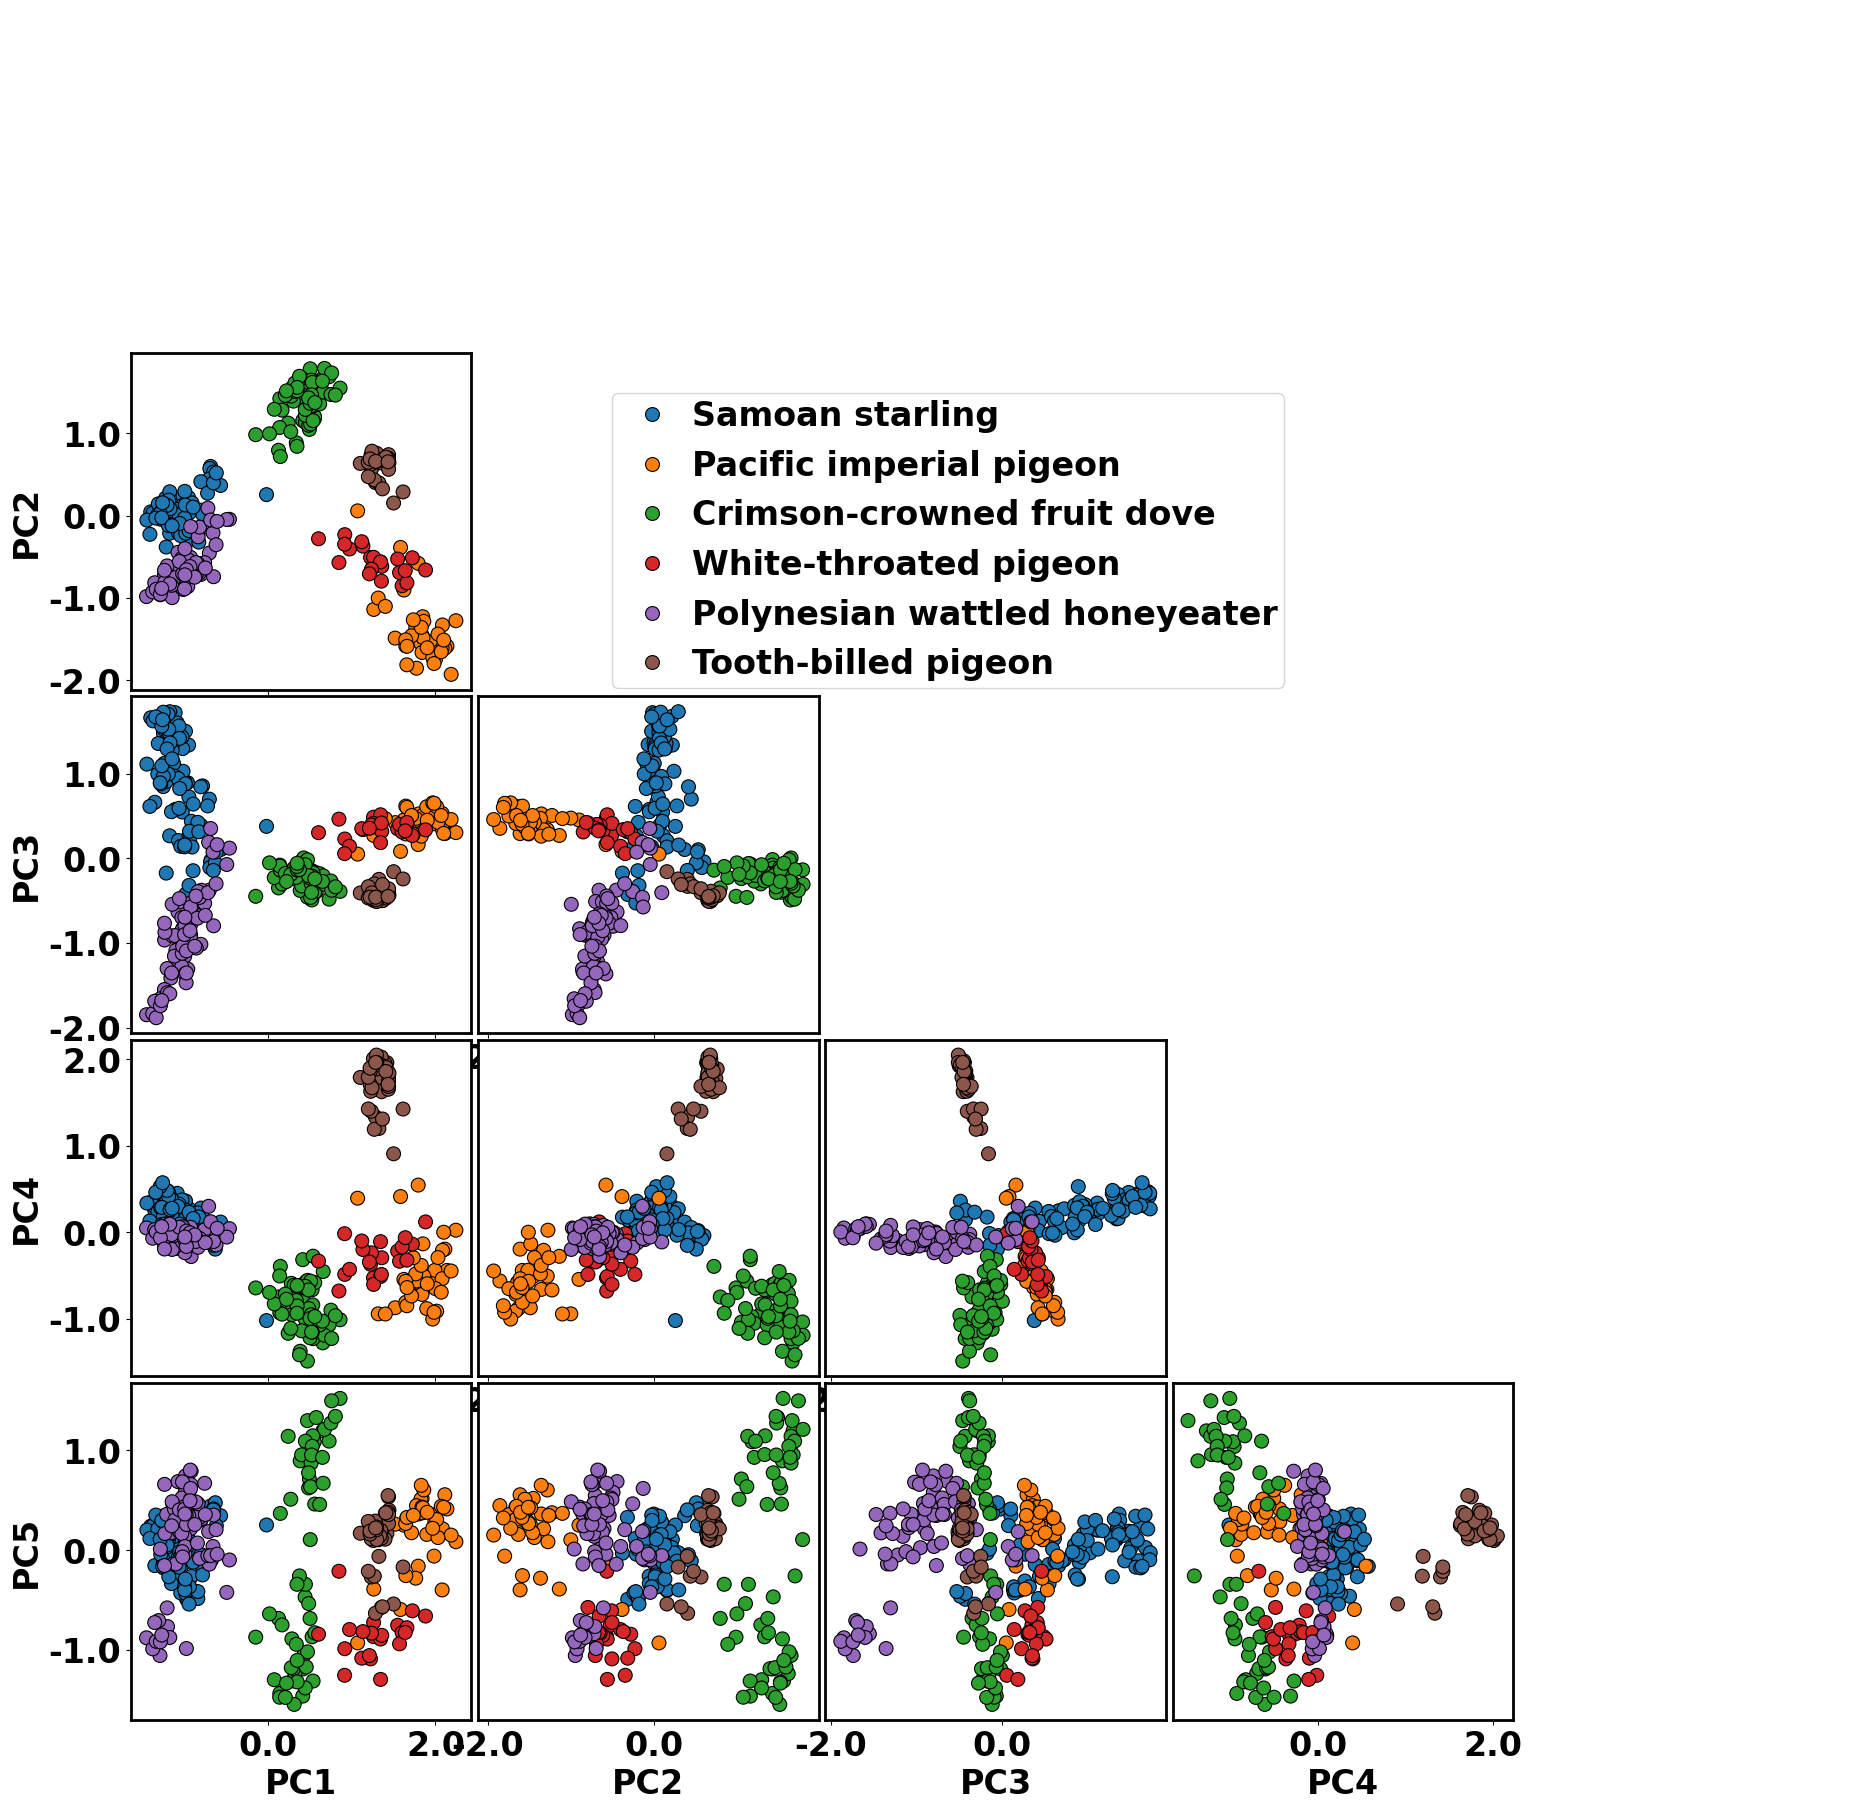

In [177]:
plot_pairplot_pca(bvc_embeddings, bvc_labels, '',save_path='./plots/top_5_perch.png')

### Silhouette Score, Davies-Bouldin Index, Within-Cluster Sum of Squares

In [43]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [44]:
# Define the calculate_silhouette_score and calculate_db_index functions
def calculate_silhouette_score(embeddings, labels):
    from sklearn.metrics import silhouette_score
    score = silhouette_score(embeddings, labels)
    return round(score, 3)

def calculate_db_index(embeddings, labels):
    from sklearn.metrics import davies_bouldin_score
    score = davies_bouldin_score(embeddings, labels)
    return round(score, 3)

# def calculate_wcss(embeddings, labels):
#     from sklearn.metrics import pairwise_distances_argmin_min
#     import numpy as np

#     unique_labels = np.unique(labels)
#     centroids = np.array([embeddings[labels == label].mean(axis=0) for label in unique_labels])
#     closest, _ = pairwise_distances_argmin_min(embeddings, centroids)
#     wcss = sum(np.sum((embeddings[i] - centroids[closest[i]]) ** 2) for i in range(len(embeddings)))
#     return round(wcss, 3)

def calculate_ch_score(embeddings, labels):
    from sklearn.metrics import calinski_harabasz_score

    ch_score = calinski_harabasz_score(embeddings, labels)
    return round(ch_score,3)


def calculate_wcss(embeddings, labels):
    unique_labels = np.unique(labels)
    wcss = 0
    for label in unique_labels:
        cluster_points = embeddings[labels == label]
        centroid = cluster_points.mean(axis=0)
        wcss += ((cluster_points - centroid) ** 2).sum()
    return round(wcss, 3)

# def calculate_wcss(embeddings, labels):
#     # Ensure embeddings is a numpy array
#     embeddings = np.array(embeddings)
    
#     # Convert string labels to integers
#     le = LabelEncoder()
#     numeric_labels = le.fit_transform(labels)
    
#     # Group embeddings by label
#     clusters = defaultdict(list)
#     for embedding, label in zip(embeddings, numeric_labels):
#         clusters[label].append(embedding)
    
#     # Calculate WCSS
#     wcss = 0
#     for label, points in clusters.items():
#         points = np.array(points)  # Ensure points is a numpy array
#         center = np.mean(points, axis=0)
#         wcss += np.sum(np.sum((points - center) ** 2, axis=1))
    
#     return round(wcss, 3)


# def calculate_ari()
# ari = adjusted_rand_score(labels, labels)
# nmi = normalized_mutual_info_score(labels, labels)

# Calculate dissimilarity/similarity metrics
euclidean_dist = euclidean_distances(birdnet_embeddings)
cosine_dist = cosine_distances(birdnet_embeddings)


In [45]:
# Silhouette Score
silhouette_avg = calculate_silhouette_score(birdnet_embeddings, birdnet_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin Index
db_index = calculate_db_index(birdnet_embeddings, birdnet_labels)
print(f'Davies-Bouldin Index: {db_index}')


ch = calculate_ch_score(birdnet_embeddings, birdnet_labels)
print(f'calinski_harabasz_score: {ch}')


wcss = calculate_wcss(birdnet_embeddings, birdnet_labels)
print(f"The Within-Cluster Sum of Squares is: {wcss}")

Silhouette Score: 0.16200000047683716
Davies-Bouldin Index: 2.14
calinski_harabasz_score: 35.58
The Within-Cluster Sum of Squares is: 25267.302


In [46]:
# Silhouette Score
silhouette_avg = calculate_silhouette_score(birdnet_embeddings_train, birdnet_labels_train)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin Index
db_index = calculate_db_index(birdnet_embeddings_train, birdnet_labels_train)
print(f'Davies-Bouldin Index: {db_index}')


ch = calculate_ch_score(birdnet_embeddings_train, birdnet_labels_train)
print(f'calinski_harabasz_score: {ch}')


wcss = calculate_wcss(birdnet_embeddings_train, birdnet_labels_train)
print(f"The Within-Cluster Sum of Squares is: {wcss}")


Silhouette Score: 0.137
Davies-Bouldin Index: 2.111
calinski_harabasz_score: 34.233
The Within-Cluster Sum of Squares is: 29596.646


# ALL EMBEDDINGS

In [47]:
model_names = [
    'resnet18', 'resnet34', 'resnet50', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2','efficientnet-b3',
    'resnext', 'densenet', 'alexnet', 'vgg', 'mobilenet', 'vit', 'cvit', 'bvc', 'birdnet', 'birdnet-realtime'
]

all_embeddings = [resnet_embeddings[key] for key in resnet_embeddings.keys()]+[efficientnet_embeddings[key] for key in efficientnet_embeddings.keys()]+[resnext_embeddings,
                densenet_embeddings,
                alexnet_embeddings,
                vgg_embeddings,
                mobilenet_embeddings,
                vit_embeddings,
                cvit_embeddings,
                bvc_embeddings,
                birdnet_embeddings_train,
                birdnet_embeddings]

# Combine all embeddings and labels
# all_embeddings = [
#     resnet_embeddings['resnet18'], resnet_embeddings['resnet34'], resnet_embeddings['resnet50'],
#     efficientnet_embeddings['efficientnet-b0'], efficientnet_embeddings['efficientnet-b1'], efficientnet_embeddings['efficientnet-b2'],
#     resnext_embeddings, densenet_embeddings, alexnet_embeddings, vgg_embeddings, mobilenet_embeddings,
#     vit_embeddings, cvit_embeddings, bvc_embeddings, birdnet_embeddings_train
# ]

all_labels = [labels]*12 + [vit_labels,cvit_labels,bvc_labels,birdnet_labels_train,birdnet_labels]

In [86]:
save_embeddings_and_labels(model_name = 'bvc', embeddings = unk_bvc_embeddings, labels = unk_bvc_labels, output_dir='test_embeddings')


Saved embeddings to test_embeddings/bvc_embeddings.npy
Saved labels to test_embeddings/bvc_labels.npy


In [87]:
save_embeddings_and_labels(model_name = 'birdnet-realtime', embeddings = unk_birdnet_embeddings, labels = unk_birdnet_labels, output_dir='test_embeddings')

Saved embeddings to test_embeddings/birdnet-realtime_embeddings.npy
Saved labels to test_embeddings/birdnet-realtime_labels.npy


In [89]:
np.save('/home/jupyter/research/test_embeddings/unk_filenames.npy',unk_files)

In [54]:
# Iterate over model names, embeddings, and labels
for model_name, embeddings, labels in zip(model_names, all_embeddings, all_labels):
    print(f'Model: {model_name}\n')
    save_embeddings_and_labels(model_name, embeddings, labels, output_dir='models')
    
    # Silhouette Score
    silhouette_avg = calculate_silhouette_score(embeddings, labels)
    print(f'Silhouette Score: {silhouette_avg}')

    # Davies-Bouldin Index
    db_index = calculate_db_index(embeddings, labels)
    print(f'Davies-Bouldin Index: {db_index}')

    # Within-Cluster Sum of Squares
    wcss = calculate_wcss(embeddings, labels)
    print(f'Within-Cluster Sum of Squares: {wcss}')
    
    ch = calculate_ch_score(embeddings,labels)
    print(f"The Calinski-Harabasz Index is: {ch}")
    
    print('\n')

Model: resnet18

Saved embeddings to models/resnet18_embeddings.npy
Saved labels to models/resnet18_labels.npy
Silhouette Score: 0.11299999803304672
Davies-Bouldin Index: 1.885
Within-Cluster Sum of Squares: 12499.338
The Calinski-Harabasz Index is: 51.478


Model: resnet34

Saved embeddings to models/resnet34_embeddings.npy
Saved labels to models/resnet34_labels.npy
Silhouette Score: 0.07400000095367432
Davies-Bouldin Index: 2.139
Within-Cluster Sum of Squares: 14742.12
The Calinski-Harabasz Index is: 39.706


Model: resnet50

Saved embeddings to models/resnet50_embeddings.npy
Saved labels to models/resnet50_labels.npy
Silhouette Score: 0.11400000005960464
Davies-Bouldin Index: 2.175
Within-Cluster Sum of Squares: 10844.881
The Calinski-Harabasz Index is: 43.235


Model: efficientnet-b0

Saved embeddings to models/efficientnet-b0_embeddings.npy
Saved labels to models/efficientnet-b0_labels.npy
Silhouette Score: 0.09799999743700027
Davies-Bouldin Index: 2.043
Within-Cluster Sum of Squa

In [ ]:
import pandas as pd
import numpy as np

data = {
    'resnet18': [0.113, 1.885, 51.478],
    'resnet34': [0.074, 2.139, 39.706],
    'resnet50': [0.114, 2.175, 43.235],
    'efficientnet-b0': [0.098, 2.043, 40.489],
    'efficientnet-b1': [0.072, 1.968, 36.718],
    'efficientnet-b2': [0.088, 2.191, 33.649],
    'efficientnet-b3': [0.085, 2.240, 35.247],
    'resnext': [0.082, 2.260, 32.818],
    'densenet': [0.090, 2.174, 40.689],
    'alexnet': [0.146, 1.791, 68.461],
    'vgg': [0.104, 2.049, 40.953],
    'mobilenet': [0.085, 2.294, 37.685],
    'vit': [-0.009, 3.830, 14.547],
    'cvit': [-0.003, 3.442, 16.467],
    'bvc': [0.181, 1.993, 37.48],
    'birdnet': [0.137, 2.111, 34.233],
    'birdnet-realtime': [0.162, 2.140, 35.580]
}

df = pd.DataFrame.from_dict(data, orient='index', 
                            columns=['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'])

# Normalize the scores
df['Silhouette_norm'] = (df['Silhouette'] - df['Silhouette'].min()) / (df['Silhouette'].max() - df['Silhouette'].min())
df['Davies-Bouldin_norm'] = 1 - (df['Davies-Bouldin'] - df['Davies-Bouldin'].min()) / (df['Davies-Bouldin'].max() - df['Davies-Bouldin'].min())
df['Calinski-Harabasz_norm'] = (df['Calinski-Harabasz'] - df['Calinski-Harabasz'].min()) / (df['Calinski-Harabasz'].max() - df['Calinski-Harabasz'].min())

# Calculate overall score
df['Overall_Score'] = (df['Silhouette_norm'] + df['Davies-Bouldin_norm'] + df['Calinski-Harabasz_norm']) / 3

# Sort by overall score
df_sorted = df.sort_values('Overall_Score', ascending=False)

print(df_sorted[['Overall_Score', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']])


## apply PCA then calculate

In [ ]:
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def create_models_data(model_names, all_embeddings, all_labels):
    models_data = {}
    for model_name, embeddings,labels in zip(model_names, all_embeddings,all_labels):
        models_data[model_name] = (embeddings, labels)
    return models_data


# def calculate_metrics(embeddings, labels):
#     silhouette_avg = silhouette_score(embeddings, labels)
#     db_index = davies_bouldin_score(embeddings, labels)
    
#     def calculate_wcss(embeddings, labels):
#         unique_labels = np.unique(labels)
#         wcss = 0
#         for label in unique_labels:
#             cluster_points = embeddings[labels == label]
#             centroid = cluster_points.mean(axis=0)
#             wcss += ((cluster_points - centroid) ** 2).sum()
#         return round(wcss, 3)

#     wcss = calculate_wcss(embeddings, labels)
#     ari = adjusted_rand_score(labels, labels)
#     nmi = normalized_mutual_info_score(labels, labels)
#     euclidean_dist = np.mean(euclidean_distances(embeddings))
#     cosine_dist = np.mean(cosine_distances(embeddings))
    
#     return {
#         'Silhouette Score': silhouette_avg,
#         'Davies-Bouldin Index': db_index,
#         'Within-Cluster Sum of Squares': wcss,
#         'Adjusted Rand Index': ari,
#         'Normalized Mutual Information': nmi,
#         'Mean Euclidean Distance': euclidean_dist,
#         'Mean Cosine Distance': cosine_dist
#     }

def calculate_metrics_with_pca(embeddings, labels, n_components=256):
    # Standardize the data
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Apply PCA
    # pca = PCA(n_components=n_components)
    # embeddings_pca = pca.fit_transform(embeddings_scaled)
    
    svd = TruncatedSVD(n_components=n_components)
    embeddings_pca = svd.fit_transform(embeddings_scaled)
    
    # Calculate metrics
    silhouette = silhouette_score(embeddings_pca, labels)
    davies_bouldin = davies_bouldin_score(embeddings_pca, labels)
    calinski_harabasz = calinski_harabasz_score(embeddings_pca, labels)
    
    return silhouette, davies_bouldin, calinski_harabasz

# Function to process all models
def process_models(models_data, n_components):
    results = {}
    for model_name, (embeddings, labels) in models_data.items():
        silhouette, davies_bouldin, calinski_harabasz = calculate_metrics_with_pca(embeddings, labels, n_components)
        results[model_name] = {
            'Silhouette': silhouette,
            'Davies-Bouldin': davies_bouldin,
            'Calinski-Harabasz': calinski_harabasz
        }
    return results

# Create the models_data dictionary
models_data = create_models_data(model_names, all_embeddings, all_labels)

results = process_models(models_data, n_components=100)

# Print results
for model, scores in results.items():
    print(f"\nModel: {model}")
    for metric, value in scores.items():
        print(f"{metric}: {value:.3f}")

In [ ]:
# (score - min): Shifts the minimum value to zero.
# (max - min): Represents the range of the original data.
# Dividing by the range scales all values to [0, 1].

import pandas as pd

# Create a DataFrame from the results
df = pd.DataFrame(results).T

# Normalize scores (higher is better for all)
df['Silhouette_norm'] = (df['Silhouette'] - df['Silhouette'].min()) / (df['Silhouette'].max() - df['Silhouette'].min())
df['Davies-Bouldin_norm'] = 1 - (df['Davies-Bouldin'] - df['Davies-Bouldin'].min()) / (df['Davies-Bouldin'].max() - df['Davies-Bouldin'].min())
df['Calinski-Harabasz_norm'] = (df['Calinski-Harabasz'] - df['Calinski-Harabasz'].min()) / (df['Calinski-Harabasz'].max() - df['Calinski-Harabasz'].min())

# Calculate overall score
df['Overall_Score'] = (df['Silhouette_norm'] + df['Davies-Bouldin_norm'] + df['Calinski-Harabasz_norm']) / 3

# Sort by overall score
df_sorted = df.sort_values('Overall_Score', ascending=False)

print(df_sorted[['Overall_Score', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']])

In [ ]:
plot_pairplot_pca(bvc_embeddings, labels, 'Pairplot of Top 5 PCA Components')#,save_path='top_5_with_unk.png')

In [ ]:
plot_reduction(bvc_embeddings, bvc_labels, 'TSNE of birdnet Embeddings', method='tsne')

In [ ]:
plot_reduction(np.vstack((birdnet_embeddings_train,birdnet_embeddings_test)), np.hstack((birdnet_labels_train,birdnet_labels_test)), 'TSNE of birdnet Embeddings', method='tsne')

In [ ]:
plot_reduction(birdnet_embeddings_train, labels, 'TSNE of birdnet Embeddings', method='tsne')

In [ ]:
plot_reduction(birdnet_embeddings, labels, 'TSNE of Birdnet Embeddings', method='tsne')

In [ ]:
birdnet_embeddings.shape

In [ ]:
len(np.where(birdnet_embeddings[2]==0)[0])

In [90]:
resnet_models.keys()

dict_keys(['resnet18', 'resnet34', 'resnet50'])

## Prediction

In [91]:
test_densenet_embeddings, _ = generate_embeddings(test_dataloader, densenet_model)
test_alexnet_embeddings, _ = generate_embeddings(test_dataloader, alexnet_model)
test_resnet18_embeddings, _ = generate_embeddings(test_dataloader, resnet_models['resnet18'])

In [93]:
save_embeddings_and_labels(model_name = 'alexnet', embeddings = test_alexnet_embeddings, labels = unk_bvc_labels, output_dir='test_embeddings')
save_embeddings_and_labels(model_name = 'resnet18', embeddings = test_resnet18_embeddings, labels = unk_bvc_labels, output_dir='test_embeddings')


Saved embeddings to test_embeddings/alexnet_embeddings.npy
Saved labels to test_embeddings/alexnet_labels.npy
Saved embeddings to test_embeddings/resnet18_embeddings.npy
Saved labels to test_embeddings/resnet18_labels.npy


In [94]:
test_alexnet_embeddings.shape

(94, 4096)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# Function to normalize embeddings using L2 normalization
def normalize_embeddings(embeddings):
    return normalize(embeddings, axis=1, norm='l2')

# Function to convert similarity scores to probabilities using softmax
def softmax(scores):
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  # Subtract max for numerical stability
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Calculate prototypes using median or trimmed mean
def calculate_prototypes(embeddings, labels, use_median=True):
    unique_labels = np.unique(labels)
    prototypes = {}
    for label in unique_labels:
        label_embeddings = embeddings[labels == label]
        if use_median:
            prototypes[label] = np.median(label_embeddings, axis=0, keepdims=True)
        else:
            # Trimmed mean: remove the highest and lowest 10% of values
            sorted_embeddings = np.sort(label_embeddings, axis=0)
            trim_fraction = int(0.1 * label_embeddings.shape[0])
            trimmed_embeddings = sorted_embeddings[trim_fraction:-trim_fraction]
            prototypes[label] = np.mean(trimmed_embeddings, axis=0, keepdims=True)
    return prototypes


def calculate_prototype_matrix(prototypes):
    # Flatten prototype dictionary to arrays
    prototype_labels = []
    prototype_matrix = []
    for label, center in prototypes.items():
        prototype_labels.append(label)
        prototype_matrix.append(center)
    prototype_matrix = np.array(prototype_matrix).squeeze()
    return prototype_matrix,prototype_labels




def bird_classifier(target_embeddings, prototypes,unknown_files):
    
    prototype_matrix,prototype_labels = calculate_prototype_matrix(prototypes)
    
    # Compute cosine similarity between new embeddings and prototypes
    similarities = cosine_similarity(target_embeddings, prototype_matrix)

    # Convert similarities to probabilities
    probabilities = softmax(similarities)

    # Define a threshold for assigning labels
    threshold = 0.8  # Adjust this based on your requirements

    # Assign labels and calculate confidence scores based on the threshold
    predicted_labels = []
    confidence_scores = []
    for i, (prob, similarity) in enumerate(zip(probabilities, similarities)):
        max_similarity = np.max(similarity)
        if max_similarity >= threshold:
            predicted_label = prototype_labels[np.argmax(similarity)]
        else:
            predicted_label = 'unknown'
        predicted_labels.append(predicted_label)
        confidence_scores.append(max_similarity)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Filename': [filename.split('/')[-1] for filename in unknown_files],
        'Predicted Label': predicted_labels,
        'Similarity Score': confidence_scores,
        'Probabilities': list(probabilities)
    })
    return results_df

In [ ]:
def make_prediction(known_embeddings,known_labels,unknown_embeddings,unknown_files):
    # Normalize known embeddings
    normalized_known_embeddings = normalize_embeddings(known_embeddings)

    # Apply Truncated SVD to reduce dimensionality
    svd = TruncatedSVD(n_components=50)  # Reduce to 50 dimensions
    reduced_embeddings = svd.fit_transform(normalized_known_embeddings)

    prototypes = calculate_prototypes(reduced_embeddings, known_labels)


    # Example new bird sound embeddings (to classify)
    normalized_new_embeddings = normalize_embeddings(unknown_embeddings)
    reduced_new_embeddings = svd.transform(normalized_new_embeddings)

    results_df = bird_classifier(reduced_new_embeddings,prototypes,unknown_files)
    return results_df

def load_audio_files(root_dir):
    files = []
    labels = []

    for bird_folder in os.listdir(root_dir):
        bird_path = os.path.join(root_dir, bird_folder, 'segmented_audio', 'denoised')
        if os.path.isdir(bird_path):
            for file_name in os.listdir(bird_path):
                if file_name.endswith('.wav'):
                    files.append(os.path.join(bird_path, file_name))
                    labels.append(bird_folder)

    return files, labels

In [77]:
unk_files,_ = load_audio_files(test_directory)

## Alexnet

In [ ]:
alex_df = make_prediction(alexnet_embeddings,birdnet_labels,test_alexnet_embeddings,unk_files)

In [ ]:
unk_files[:3]

In [ ]:
alex_df['Filename'].tolist()

In [ ]:
alex_df[:50]

## Densenet

In [ ]:
dense_df = make_prediction(densenet_embeddings,birdnet_labels,test_densenet_embeddings,unknown_files)

In [ ]:
dense_df[50:]

In [ ]:
birdnet_df = make_prediction(birdnet_embeddings,birdnet_labels,birdnet_embeddings_test,unknown_files)

In [ ]:
alex_df.to_csv('alexnet_prediction.csv',index=False)

In [ ]:
dense_df.to_csv('densenet_prediction.csv', index=False)

In [ ]:
birdnet_df[:40]